## Evolution of condition number of outer-product and full Hessian during training

In a well controlled setting of binary classification of two gaussian distributed datasets we are studying the evolution of the condition number of the outer-product Hessian and the full Hessian over the course of training.

Specifically we are evaluating:

- the effect of width $m$ and 
- depth $L$ of a linear neural network 
and other changes to the network, such as 
- adding non-linearities,
    - e.g. ReLU, 
    - leaky-ReLU and 
    - GeLU, or 
- the effect that residual connections have. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import time
from IPython.display import display, Latex
from collections import defaultdict

from torch.distributions.multivariate_normal import MultivariateNormal
from datetime import datetime as dt

from networks import *
from network_derivatives import *

from tqdm.notebook import tqdm

In [2]:
torch.set_default_dtype(torch.float64)

plt.rcParams["figure.figsize"] = (4,4)

In [3]:
def train_network(x_train, y_train, loss_func, network, optimizer, lr, epochs, calc_cond_num=False, verbose_level=0, calc_every_x_epoch=10):
    
    if optimizer == 'SGD':
        opt = optim.SGD(network.parameters(), lr=lr)
    elif optimizer == 'Adam':
        opt = optim.Adam(network.parameters(), lr=lr)
    else:
        ValueError('Unknown optimizer')

    loss_values = [loss_func(network(x_train), y_train).detach()]
    grad_norm_squared = []
    

#     print(_H_cond, _H_o_cond, _lam_abs_min, _lam_abs_max, _diff_H_H_o)
    
    if calc_cond_num == True:
        _H_cond, _H_o_cond, _lam_abs_min_H, _lam_abs_max_H, _lam_abs_min_H_o, _lam_abs_max_H_o, _diff_H_H_o = calc_condition_num(network,
                                                                    x_train,y_train,
                                                                    loss_func)
        H_cond = [_H_cond]
        H_o_cond = [_H_o_cond]
        lam_abs_min_H = [_lam_abs_min_H]
        lam_abs_max_H = [_lam_abs_max_H]
        lam_abs_min_H_o = [_lam_abs_min_H_o]
        lam_abs_max_H_o = [_lam_abs_max_H_o]
        diff_H_H_o = [_diff_H_H_o]
        
    print('Epoch: 0 \t loss= %10.3e' %loss_func(network(x_train), y_train).detach())

    for epoch in tqdm(range(epochs)):
        if calc_cond_num == True and epoch%calc_every_x_epoch==0:
            _H_cond, _H_o_cond, _lam_abs_min_H, _lam_abs_max_H, _lam_abs_min_H_o, _lam_abs_max_H_o, _diff_H_H_o = calc_condition_num(network,
                                                                        x_train,y_train,
                                                                        loss_func)
            H_cond.append(_H_cond)
            H_o_cond.append(_H_o_cond)
            lam_abs_min_H.append(_lam_abs_min_H)
            lam_abs_max_H.append(_lam_abs_max_H)
            lam_abs_min_H_o.append(_lam_abs_min_H_o)
            lam_abs_max_H_o.append(_lam_abs_max_H_o)
            diff_H_H_o.append(_diff_H_H_o)
        
        for xb, yb in train_dl:
            pred = network(xb)        
            loss = loss_func(pred, yb, reduction='mean')

            loss.backward()
            
            grad_norm_sq = sum([torch.linalg.norm(param.grad)**2 for param in network.parameters()])
            grad_norm_squared.append(grad_norm_sq)
            
            opt.step()
            opt.zero_grad()

            if verbose_level >= 2:
                print('loss: ', loss_func(network(x_train), y_train).detach())
                    
                print('gradient_norm_sqaured: ', grad_norm_squared)

        
        loss_values.append(loss_func(network(x_train), y_train).detach())
        
        if verbose_level == 0 and epoch%int(epochs/10 + 1) ==0:
            print('Epoch: %d \t loss= %10.4e' %(epoch+1, loss_func(network(x_train), y_train).detach()))
        elif verbose_level >= 1:
            print('Epoch: %d \t loss= %10.4e' %(epoch+1, loss_func(network(x_train), y_train).detach()))
         
        
    print('Epoch: %d \t loss= %10.4e' %(epoch+1, loss_func(network(x_train), y_train).detach()))
    if calc_cond_num == True:
        return loss_values, grad_norm_squared, H_cond, H_o_cond, lam_abs_min_H, lam_abs_max_H, lam_abs_min_H_o, lam_abs_max_H_o, diff_H_H_o
    else:
        return loss_values, grad_norm_squared

### Gaussian data setup
In the following we will create a synthetic Gaussian dataset for binary classification.
Due to the simplicity of the problem we can control the dimensionality of the input as well as the "difficulty" of the classification task by varying the distance of the mean and variance of both Gaussian blops.  

In [4]:
def generate_gaussian_data_for_bin_classification(n, mean_1,mean_2,cov_1,cov_2):
    
    # define multi-variate normal generator with given means and covariance
    mvrn_class1 = MultivariateNormal(mean_1,cov_1)
    mvrn_class2 = MultivariateNormal(mean_2,cov_2)
    
    # sample n (input,output) tuples
    x_class1 = mvrn_class1.rsample((n,))    
    x_class2 = mvrn_class2.rsample((n,))
    
    # define labels
    y_class1 = np.ones((n,1))
    y_class2 = -np.ones((n,1))

    x_data = np.concatenate((x_class1,x_class2))
    y_data = np.concatenate((y_class1,y_class2))
    
    # shuffle data
    perm = np.random.permutation(np.arange(2*n))
    x_data = x_data[perm,:]
    y_data = y_data[perm]


    return torch.tensor(x_data), torch.tensor(y_data)

In [5]:
def accuracy(out, yb):
    preds = torch.sign(out)
#     yb = torch.argmax(yb)
   
    return (preds == yb).float().mean()

In [6]:
# setting up Gaussian data

n = 100 # number of training data points
v = 20 # number of validation data points
m = 50 # number of test data points
d = 2 # dimensionality of the Gaussian input

mean_1 = -torch.tensor([0,5.])
mean_2 = torch.tensor([0,5.])

cov_1 = 0.25*torch.tensor([[1,0],[0,1]])
cov_2 = 0.25*torch.tensor([[1,0],[0,1]])

torch.manual_seed(314159)

x_train, y_train = generate_gaussian_data_for_bin_classification(n, mean_1,mean_2,cov_1,cov_2)
x_test, y_test = generate_gaussian_data_for_bin_classification(m, mean_1,mean_2,cov_1,cov_2)
x_val, y_val = generate_gaussian_data_for_bin_classification(v, mean_1,mean_2,cov_1,cov_2)

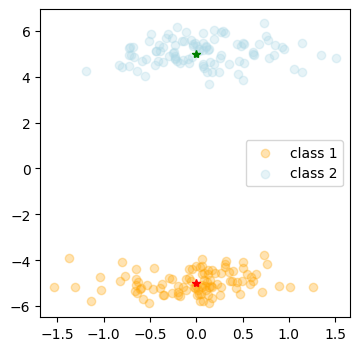

In [7]:
plt.scatter(x_train[y_train[:,0]==1,0],x_train[y_train[:,0]==1,1], color='orange', alpha=0.3, label='class 1')
plt.scatter(x_train[y_train[:,0]==-1,0],x_train[y_train[:,0]==-1,1], color='lightblue', alpha=0.3, label='class 2')

plt.legend()
plt.plot(mean_1[0],mean_1[1], '*r')
plt.plot(mean_2[0],mean_2[1], '*g')

plt.savefig('figures/synthetic_gaussian_dataset.pdf', bbox_inches='tight')

In [8]:
# Create a TensorDataset and a dataloader to iterate through the dataset more easily
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=200)

valid_ds = TensorDataset(x_val, y_val)
valid_dl = DataLoader(valid_ds, batch_size=1)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=1)

In [9]:
# calculate the empirical input covariance matrix and its condition number
cov_xx = x_train.T @ x_train / len(x_train)

cov_xx.shape

torch.Size([2, 2])

In [10]:
cov_xx_rank = torch.linalg.matrix_rank(cov_xx,atol=1e-15)
spectrum = torch.linalg.eigvalsh(cov_xx)

print('Rank of input covariance matrix: %d ' % cov_xx_rank)

print('Condition number of input covariance matrix: %.4f ' % (spectrum[-1]/spectrum[-cov_xx_rank]) )

Rank of input covariance matrix: 2 
Condition number of input covariance matrix: 93.7176 


### Set up Networks

In [11]:
# Set network configurations (input dimension, output dimension, hidden units, num_hidden_layers etc.)
# for both linear and ReLU networks

m1 = [60]
# m1 = [5,10,20,50,100,200] # hidden layer dimension
k = 1 # output dimension

L = [0] # number of hidden layers of dim "m"

kwargs={'neg_slope': 0.5} # negative slope of leaky ReLU
    
m_L_config = [] # keep track of the network configuration
num_param = [] # count the number of parameters in the model

Linear_Networks = [] # list of NN with different configurations
ReLU_Networks = [] # list of ReLU NN with different configurations
Leaky_ReLU_Networks = []
GeLU_Networks = []

Linear_Res_Networks = [] # list of res NN with different configurations
ReLU_Res_Networks = [] # list of res ReLU NN with different configurations
Leaky_ReLU_Res_Networks = []
GeLU_Res_Networks = []

# initiate linear networks of given depth L[l] with m1 hidden units each
for m in m1:
    for l in L:
        m_L_config.append((m,l))
        Linear_Networks.append(Sequential_NN(d,m,k,l,'linear'))
        ReLU_Networks.append(Sequential_NN(d,m,k,l,'relu'))
        Leaky_ReLU_Networks.append(Sequential_NN(d,m,k,l,'leaky_relu',**kwargs))
        GeLU_Networks.append(Sequential_NN(d,m,k,l,'gelu'))
        
        Linear_Res_Networks.append(Sequential_fully_skip_NN(d,m,k,l,beta=1/np.sqrt(l+2),
                                                            activation='linear'))
        
        ReLU_Res_Networks.append(Sequential_fully_skip_NN(d,m,k,l,beta=1/np.sqrt(l+2),
                                                          activation='relu'))
        
        Leaky_ReLU_Res_Networks.append(Sequential_fully_skip_NN(d,m,k,l,beta=1/np.sqrt(l+2),
                                                                     activation='leaky_relu',**kwargs))
        
        GeLU_Res_Networks.append(Sequential_fully_skip_NN(d,m,k,l,beta=1/np.sqrt(l+2),
                                                          activation='gelu'))
        
        num_param.append(sum(p.numel() for p in Sequential_fully_skip_NN(d,m,k,l).parameters()))
        
print('num parameters: ', num_param)

num parameters:  [241]


In [12]:
# define loss function
loss_func = F.mse_loss

In [13]:
print(x_train.shape, y_train.shape)

torch.Size([200, 2]) torch.Size([200, 1])


In [14]:
def train_network_configurations(networks, x_train, y_train, loss_func, m_L_config, epochs, lrs, optimizer='SGD', calc_cond_num=False, calc_every_x_epoch=10, verbose_level=0, seed=314159):
    '''
    Train list of networks of different "configurations" (#hidden units, #hidden layers)
    networks: List of networks too be trained
    m_L_config: List of configurations for each network (only needed to print information on the networks)
    epochs: number of epochs to be trained
    lrs: fixed learning-rate for each of the network
    optimizer: 'SGD' or 'Adam' optimizer
    calc_condition_num: Boolean whether to calculate  the condition number of the Hessian and the eigenvalues 
    calc_every_x_epoch: Calculates the condition number of the Hessian and the eigenvalues every x epochs
    verbose_level: 0,1,2, to track loss, mostly for debugging
    seed: seed for initializing the network according to Kaiming normal initialization
    
    '''

    # Train list of networks

    grad_norm_squared = []
    loss_values = []
    H_conds = []
    H_o_conds = []
    lam_abs_mins_H = []
    lam_abs_maxs_H = []
    lam_abs_mins_H_o = []
    lam_abs_maxs_H_o = []
    diff_H_H_os = []
    
    cond_infos = defaultdict(list)

    print('Training Networks...')

    for ind, network in enumerate(networks):


        print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))

        torch.manual_seed(seed)

        network.init_weights('kaiming_normal')
        
        if calc_cond_num==False:
            _loss_values, _grad_norm_squared = train_network(x_train, y_train, 
                                            loss_func, network, 
                                            optimizer=optimizer, 
                                            lr=lrs[ind], epochs=epochs, 
                                            calc_cond_num=False, 
                                            verbose_level=verbose_level)
        else: 
            _loss_values, _grad_norm_squared, _H_cond, _H_o_cond, _lam_abs_min_H, _lam_abs_max_H, _lam_abs_min_H_o, _lam_abs_max_H_o, _diff_H_H_o = train_network(x_train, y_train, 
                                                                                                        loss_func, network, 
                                                                                                        optimizer=optimizer, 
                                                                                                        lr=lrs[ind], epochs=epochs, 
                                                                                                        calc_cond_num=True, 
                                                                                                        verbose_level=verbose_level,
                                                                                                        calc_every_x_epoch=calc_every_x_epoch)
            cond_infos['H_conds'].append(_H_cond)
            cond_infos['H_o_conds'].append(_H_o_cond)
            cond_infos['lam_abs_mins_H'].append(_lam_abs_min_H)
            cond_infos['lam_abs_maxs_H'].append(_lam_abs_max_H)
            cond_infos['lam_abs_mins_H_o'].append(_lam_abs_min_H_o)
            cond_infos['lam_abs_maxs_H_o'].append(_lam_abs_max_H_o)
            cond_infos['diff_H_H_os'].append(_diff_H_H_o)
        
        
        grad_norm_squared.append(_grad_norm_squared)
        loss_values.append(_loss_values)
        
        
        
    if calc_cond_num==False:
        
        return loss_values, grad_norm_squared
    else: 
        
        return loss_values, grad_norm_squared, cond_infos

In [15]:
def plot_diff_H_H_O_elementwise(cond_infos, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle=''):

    plt.figure(figsize=(5,5))
    
    markers = ['^', 's', 'o', '*', 'p','v', '<']
    markevery = int(epochs/6)+1
    markevery2 = int(epochs/(6*calc_every_x_epoch))+1

    indx = list(np.arange(1,epochs,calc_every_x_epoch))
    indx.insert(0,0)

    for ind in range(len(num_param)):
        plt.semilogy(indx,np.array(cond_infos['diff_H_H_os'][ind])/(num_param[ind]**2), 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='m= %d, L=%d' % (m_L_config[ind][0], m_L_config[ind][1]))

        plt.title('Average entrywise difference of $H$ and $H_O$ w/ ' + filetitle + ' networks')
        plt.xlabel('Epochs')
        plt.ylabel(r'$\||(H - H_O)_{ij}\||_F$')
        plt.legend(loc=(1,0), ncols=1)
        
    filename = 'figures/' + 'diff_H_H_O_elementwise_' + filetitle + '.pdf'

    plt.savefig(filename, bbox_inches='tight')

In [16]:
def plot_extreme_eigenvalues(cond_infos, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle=''):

    plt.figure(figsize=(5,5))
    
    markers = ['^', 's', 'o', '*', 'p','v', '<']
    markevery = int(epochs/6)+1
    markevery2 = int(epochs/(6*calc_every_x_epoch))+1

    indx = list(np.arange(1,epochs,calc_every_x_epoch))
    indx.insert(0,0)
    for ind in range(len(num_param)):
        plt.semilogy(indx, cond_infos['lam_abs_maxs_H'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\lambda_\max(H)$, m= %d, L=%d' % (m_L_config[ind][0], m_L_config[ind][1]))
    for ind in range(len(num_param)):
        plt.semilogy(indx, cond_infos['lam_abs_mins_H'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\lambda_\min(H)$, m= %d, L=%d' % (m_L_config[ind][0], m_L_config[ind][1]))
    for ind in range(len(num_param)):
        plt.semilogy(indx, cond_infos['lam_abs_maxs_H'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\lambda_\max(H_o)$, m= %d, L=%d' % (m_L_config[ind][0], m_L_config[ind][1]))
    for ind in range(len(num_param)):
        plt.semilogy(indx, cond_infos['lam_abs_mins_H_o'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\lambda_\min(H_o)$, m= %d, L=%d' % (m_L_config[ind][0], m_L_config[ind][1]))

    plt.xlabel('Epochs')
    plt.ylabel(r'$\lambda_{\min}, \lambda_{\max}$')
    plt.legend(loc=(1,0), ncols=2)
    plt.title('Evolution of eigenvalues during training of ' + filetitle + ' networks')
    
    filename = 'figures/' + 'extreme_evals_during_training_' + filetitle + '.pdf'

    plt.savefig(filename, bbox_inches='tight')




In [17]:
def plot_training_overview(loss_values, grad_norm_squared, cond_infos, num_param, m_L_config, epochs, calc_every_x_epoch,
                          title1='MSE of ... Networks', filetitle=''):
    
    markers = ['^', 's', 'o', '*', 'p','v', '<']
    markevery = int(epochs/6)+1
    markevery2 = int(epochs/(6*calc_every_x_epoch))+1

    epsilon = 1e-13

    min_loss_val = min(np.array(loss_values).flatten())
    print('min MSE loss = %1.3e' %min_loss_val)

    loss_to_plot = np.array(loss_values) - min_loss_val + epsilon

    
    plt.figure(figsize=(9,11))

    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13)

    plt.subplot(311)
    for ind in range(len(num_param)):
        plt.semilogy(loss_to_plot[ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery+(ind%7), 
                     label='m= %d, L=%d' % (m_L_config[ind][0], m_L_config[ind][1]))

        plt.title(title1, fontsize=15)
        plt.ylabel('MSE $f-f_{\min}$', fontsize=15)
        plt.legend(loc=(1,0), ncols=1, fontsize=15)

    plt.subplot(312)
    for ind in range(len(num_param)):
        plt.semilogy(np.array(grad_norm_squared[ind])+epsilon, 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery+(ind%7), 
                     label='m= %d, L=%d' % (m_L_config[ind][0], m_L_config[ind][1]))

        plt.title('Gradient norm squared', fontsize=15)
        plt.ylabel(r'$\||\nabla f_{\theta} (x) \||^2 $', fontsize=15)
        plt.legend(loc=(1,0), ncols=1, fontsize=15)



    plt.subplot(313)

    indx = list(np.arange(1,epochs,calc_every_x_epoch))
    indx.insert(0,0)

    for ind in range(len(num_param)):
        plt.semilogy(indx,cond_infos['H_conds'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\kappa(H)$, $m= %d, L=%d$' % (m_L_config[ind][0], m_L_config[ind][1]))

    for ind in range(len(num_param)):
        plt.semilogy(indx,cond_infos['H_o_conds'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\kappa(H_O)$, $m= %d, L=%d$' % (m_L_config[ind][0], m_L_config[ind][1]))

    plt.title('Condition number of Hessian', fontsize=15)
    plt.legend(loc=(1,0), ncols=2, fontsize=15)
    plt.ylabel('$\kappa(H_O), \kappa(H)$', fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    
    filename = 'figures/' + 'training_' + filetitle + '_networks' + '.pdf'

    plt.savefig(filename, bbox_inches='tight')

## Train fully connected feed-forward networks

In [18]:
# Train Linear networks
epochs=2500
calc_every_x_epoch=50
# lrs = [0.02, 0.01, 0.01, 0.001, 0.0006, 0.0003] 
lrs = [0.001]

# loss_values_linear, grad_norm_squared_linear = train_network_configurations(Linear_Networks, x_train, y_train, loss_func, m_L_config, 
#                                                              epochs, lrs, optimizer='SGD', 
#                                                              calc_cond_num=False, 
#                                                              verbose_level=0, seed=314159)

loss_values_linear, grad_norm_squared_linear, cond_infos_linear = train_network_configurations(Linear_Networks, x_train, y_train, loss_func, m_L_config, 
                                                             epochs, lrs, optimizer='SGD', 
                                                             calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                             verbose_level=0, seed=314159)

Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  7.171e-01


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1 	 loss= 3.6724e-01
Epoch: 252 	 loss= 1.0369e-02
Epoch: 503 	 loss= 1.0341e-02
Epoch: 754 	 loss= 1.0341e-02
Epoch: 1005 	 loss= 1.0341e-02
Epoch: 1256 	 loss= 1.0341e-02
Epoch: 1507 	 loss= 1.0341e-02
Epoch: 1758 	 loss= 1.0341e-02
Epoch: 2009 	 loss= 1.0341e-02
Epoch: 2260 	 loss= 1.0341e-02
Epoch: 2500 	 loss= 1.0341e-02


min MSE loss = 1.034e-02


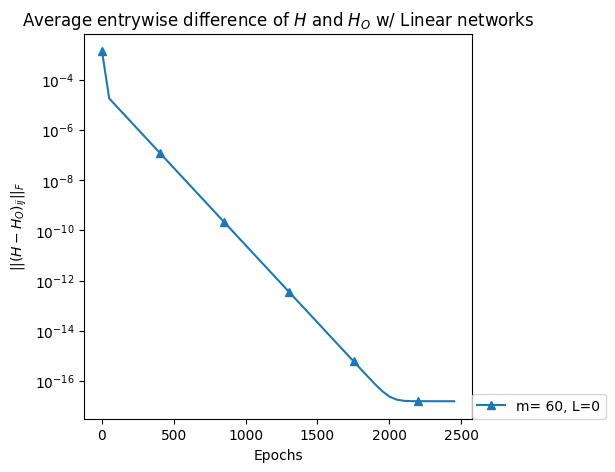

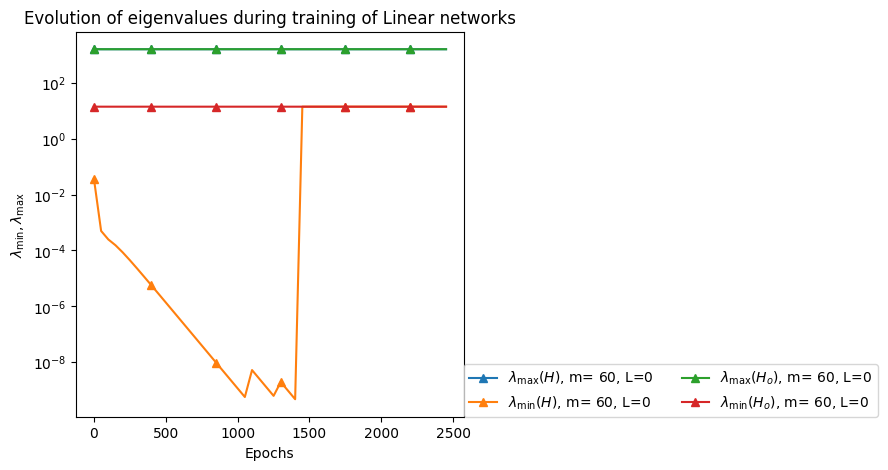

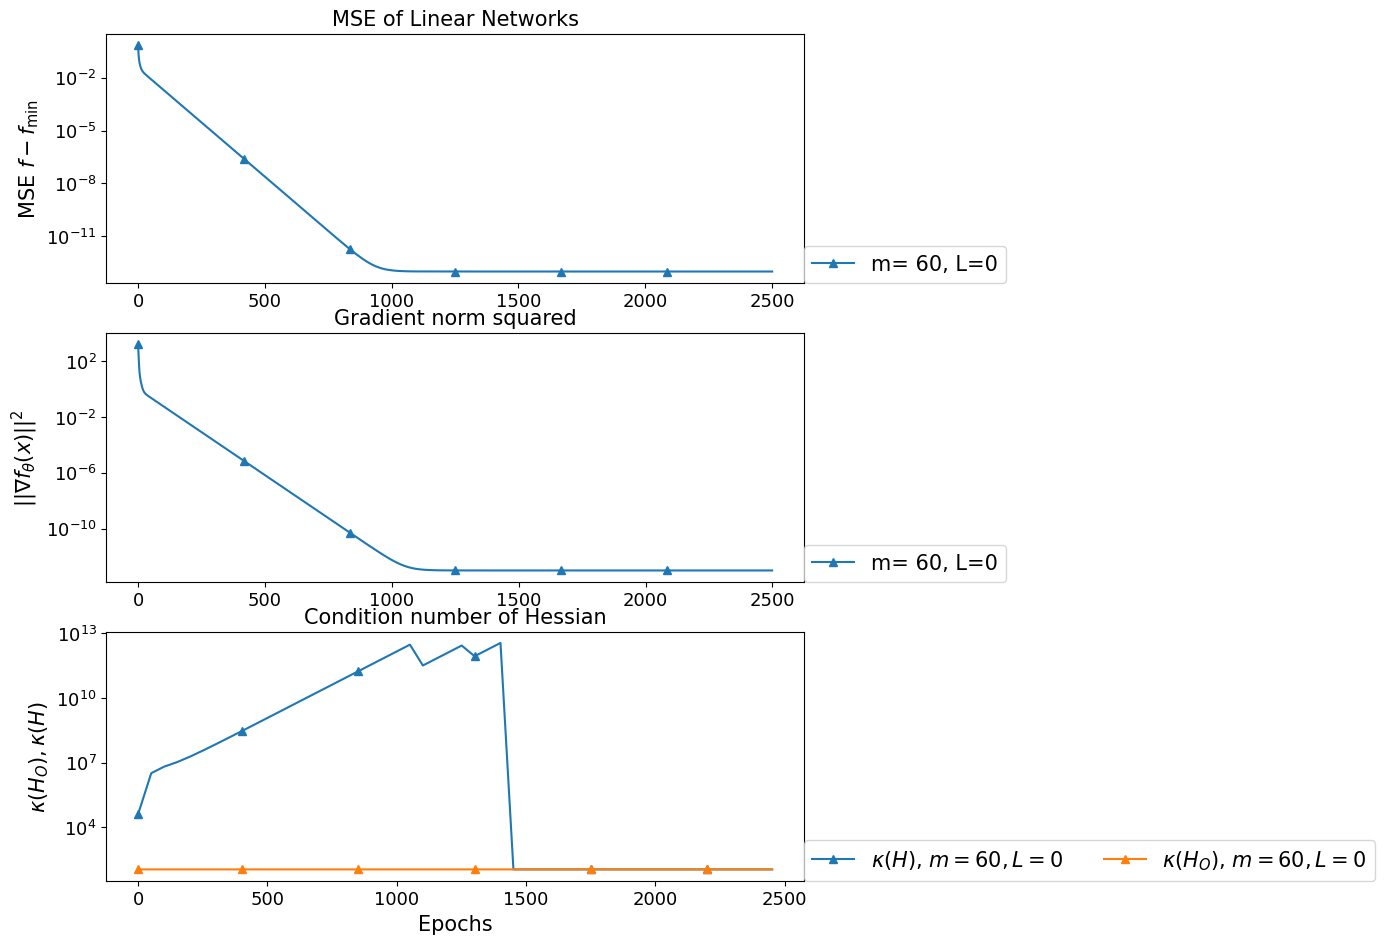

In [19]:
plot_diff_H_H_O_elementwise(cond_infos_linear, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='Linear')

plot_extreme_eigenvalues(cond_infos_linear, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='Linear')

plot_training_overview(loss_values_linear, grad_norm_squared_linear, cond_infos_linear, num_param, m_L_config, epochs, calc_every_x_epoch,
                       title1='MSE of Linear Networks', filetitle='Linear')

In [20]:
# Train ReLU networks
epochs = 200000
calc_every_x_epoch = 1000
# lrs = [0.024, 0.013, 0.011, 0.005, 0.0015, 0.001] 
lrs = [0.001]

# loss_values_relu, grad_norm_squared_relu = train_network_configurations(ReLU_Networks, x_train, y_train, loss_func, m_L_config, 
#                                                              epochs, lrs, optimizer='SGD', 
#                                                              calc_cond_num=False, 
#                                                              verbose_level=0, seed=314159)

loss_values_relu, grad_norm_squared_relu, cond_infos_relu = train_network_configurations(ReLU_Networks, x_train, y_train, loss_func, m_L_config, 
                                                             epochs, lrs, optimizer='SGD', 
                                                             calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                             verbose_level=0, seed=314159)

Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  3.624e-01


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 7.4468e-02
Epoch: 20002 	 loss= 2.9218e-04
Epoch: 40003 	 loss= 1.2926e-04
Epoch: 60004 	 loss= 7.7466e-05
Epoch: 80005 	 loss= 5.4067e-05
Epoch: 100006 	 loss= 4.1092e-05
Epoch: 120007 	 loss= 3.2816e-05
Epoch: 140008 	 loss= 2.7131e-05
Epoch: 160009 	 loss= 2.2850e-05
Epoch: 180010 	 loss= 1.9496e-05
Epoch: 200000 	 loss= 1.6802e-05


min MSE loss = 1.680e-05


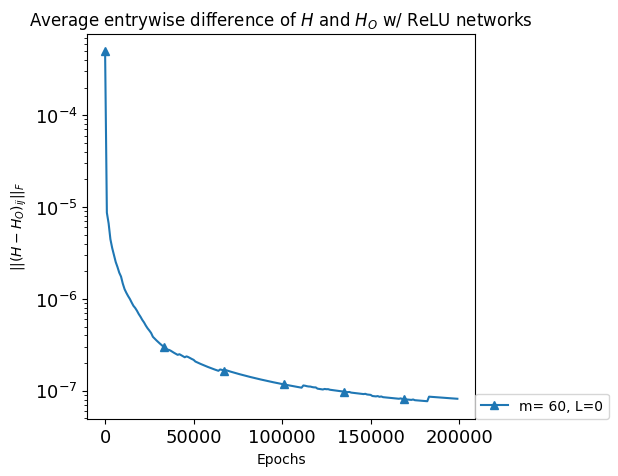

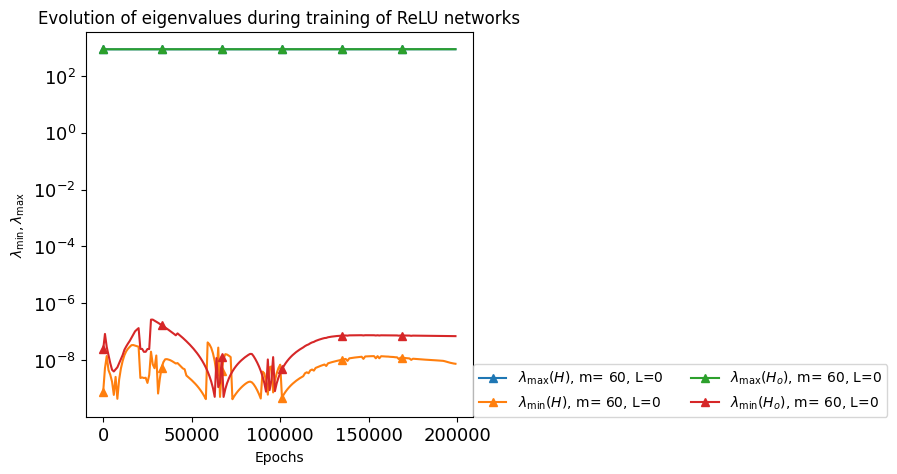

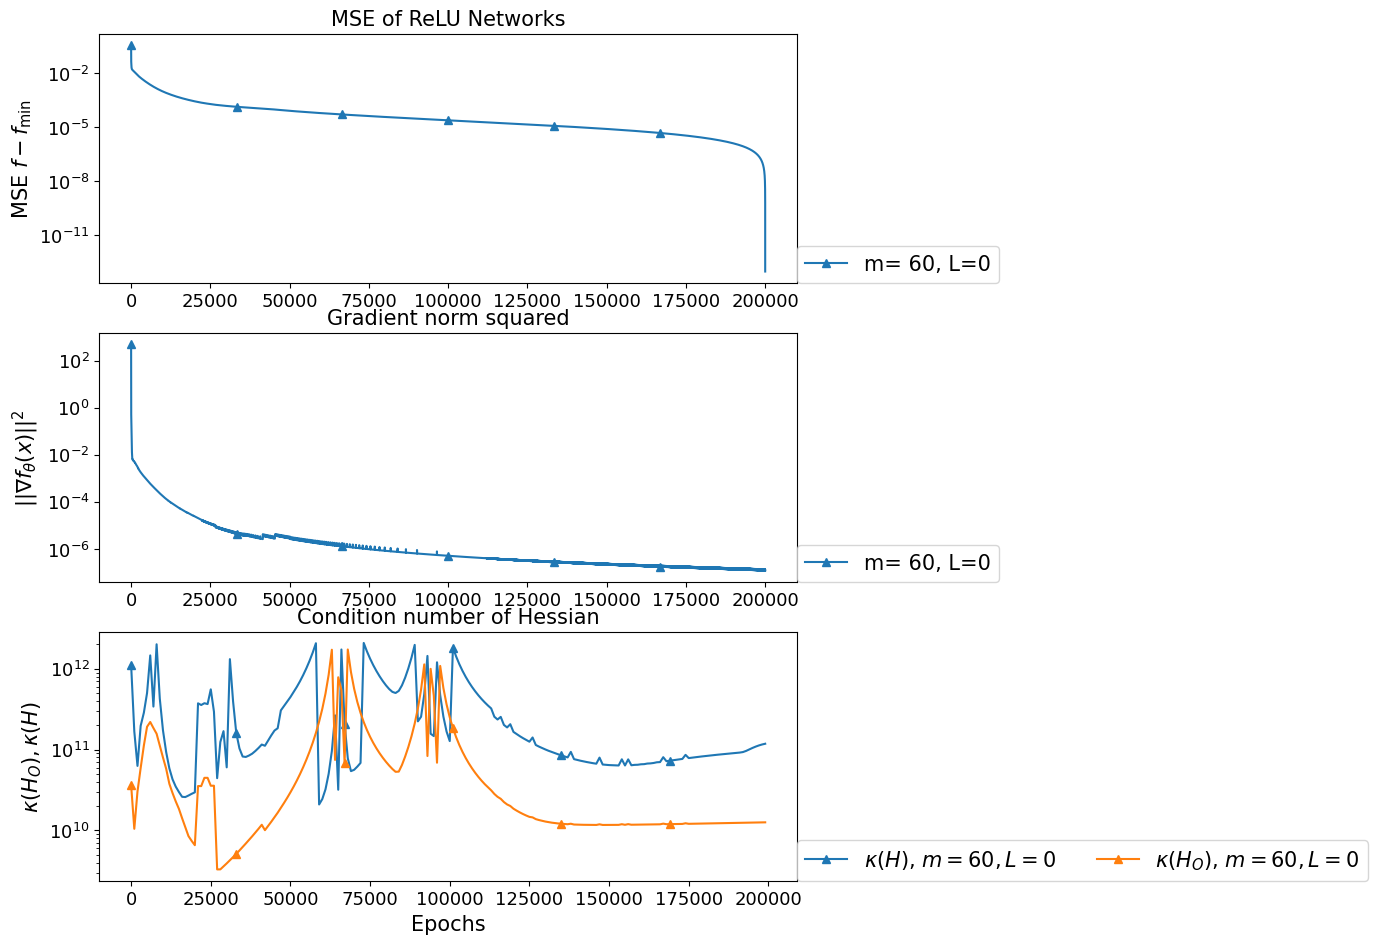

In [21]:
plot_diff_H_H_O_elementwise(cond_infos_relu, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='ReLU')

plot_extreme_eigenvalues(cond_infos_relu, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='ReLU')

plot_training_overview(loss_values_relu, grad_norm_squared_relu, cond_infos_relu, num_param, m_L_config, epochs, calc_every_x_epoch,
                       title1='MSE of ReLU Networks', filetitle='ReLU')

In [23]:
# Train Leaky ReLU networks
epochs=200000
calc_every_x_epoch= 1000
# lrs = [0.024, 0.007, 0.007, 0.004, 0.0009, 0.0005] 
lrs = [0.001]

# loss_values_leaky_relu, grad_norm_squared_leaky_relu = train_network_configurations(Leaky_ReLU_Networks, x_train, y_train, loss_func, m_L_config, 
#                                                              epochs, lrs, optimizer='SGD', 
#                                                              calc_cond_num=False, 
#                                                              verbose_level=0, seed=314159)

loss_values_leaky_relu, grad_norm_squared_leaky_relu, cond_infos_leaky_relu = train_network_configurations(Leaky_ReLU_Networks, x_train, y_train, loss_func, m_L_config, 
                                                                                 epochs, lrs, optimizer='SGD', 
                                                                                 calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                                                 verbose_level=0, seed=314159)


Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  2.232e+00


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 1.5255e+00
Epoch: 20002 	 loss= 1.8069e-03
Epoch: 40003 	 loss= 4.0558e-04
Epoch: 60004 	 loss= 1.7709e-04
Epoch: 80005 	 loss= 1.1570e-04
Epoch: 100006 	 loss= 8.2126e-05
Epoch: 120007 	 loss= 5.7096e-05
Epoch: 140008 	 loss= 4.2931e-05
Epoch: 160009 	 loss= 3.4266e-05
Epoch: 180010 	 loss= 2.8376e-05
Epoch: 200000 	 loss= 2.4261e-05


min MSE loss = 2.426e-05


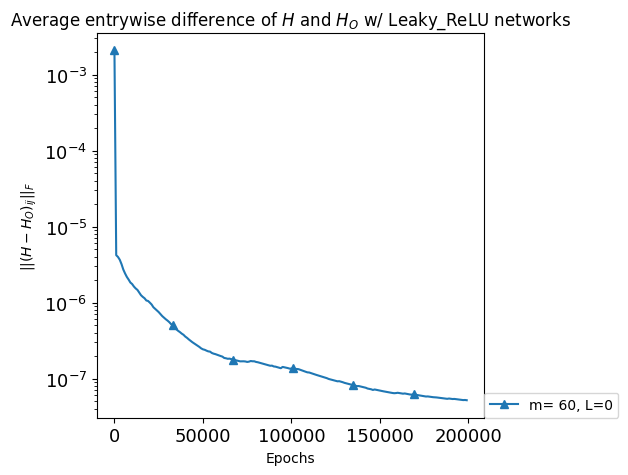

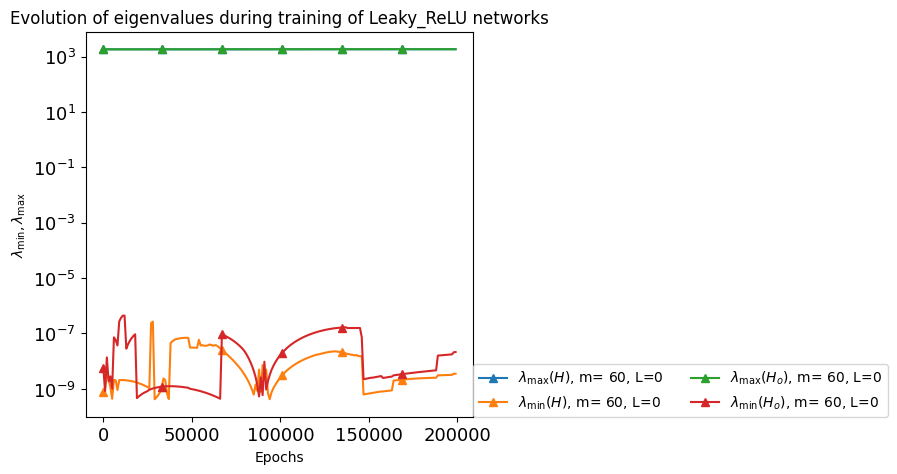

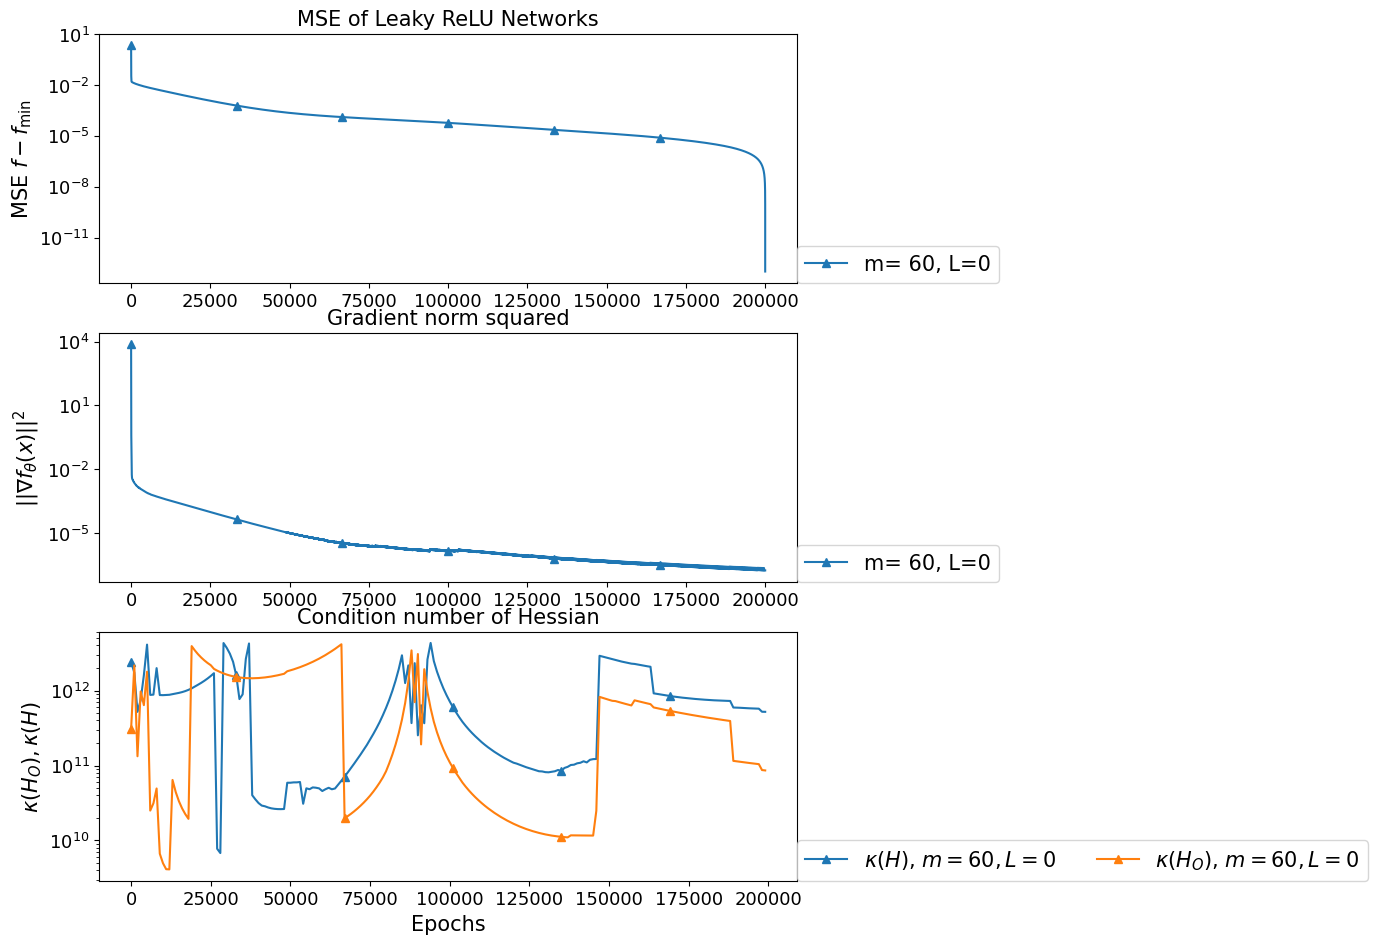

In [24]:
plot_diff_H_H_O_elementwise(cond_infos_leaky_relu, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='Leaky_ReLU')

plot_extreme_eigenvalues(cond_infos_leaky_relu, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='Leaky_ReLU')

plot_training_overview(loss_values_leaky_relu, grad_norm_squared_leaky_relu, cond_infos_leaky_relu, num_param, m_L_config, epochs, calc_every_x_epoch,
                       title1='MSE of Leaky ReLU Networks', filetitle='Leaky_ReLU')

In [25]:
# Train GeLU networks
epochs = 200000
calc_every_x_epoch= 1000
# lrs = [0.02, 0.015, 0.007, 0.004, 0.0015, 0.0005] 
lrs = [0.001]

# loss_values_gelu, grad_norm_squared_gelu = train_network_configurations(Leaky_ReLU_Networks, x_train, y_train, loss_func, m_L_config, 
#                                                              epochs, lrs, optimizer='SGD', 
#                                                              calc_cond_num=False, 
#                                                              verbose_level=0, seed=314159)

loss_values_gelu, grad_norm_squared_gelu, cond_infos_gelu = train_network_configurations(
                                                             GeLU_Networks, x_train, y_train, loss_func, m_L_config, 
                                                             epochs, lrs, optimizer='SGD', 
                                                             calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                             verbose_level=0, seed=314159)

Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Unsupported activation function. Using "linear" as non-linearity argument
Epoch: 0 	 loss=  5.284e+00


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 1.8221e+00
Epoch: 20002 	 loss= 2.0885e-04
Epoch: 40003 	 loss= 7.7124e-05
Epoch: 60004 	 loss= 5.4836e-05
Epoch: 80005 	 loss= 4.2444e-05
Epoch: 100006 	 loss= 3.4722e-05
Epoch: 120007 	 loss= 2.9538e-05
Epoch: 140008 	 loss= 2.5832e-05
Epoch: 160009 	 loss= 2.3038e-05
Epoch: 180010 	 loss= 2.0836e-05
Epoch: 200000 	 loss= 1.9040e-05


min MSE loss = 1.904e-05


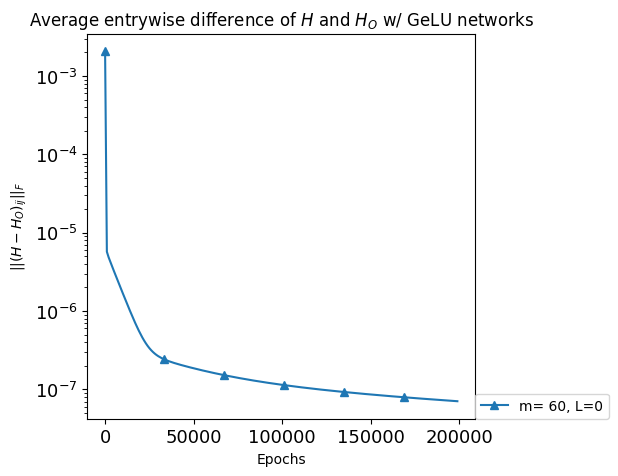

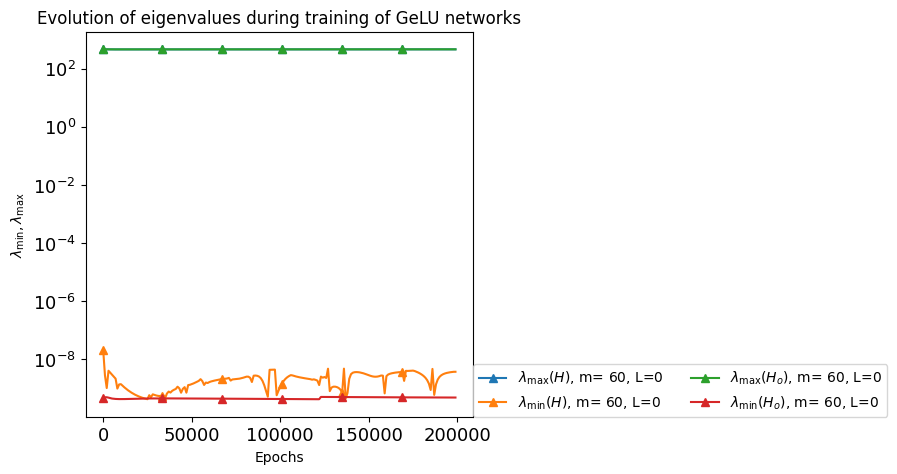

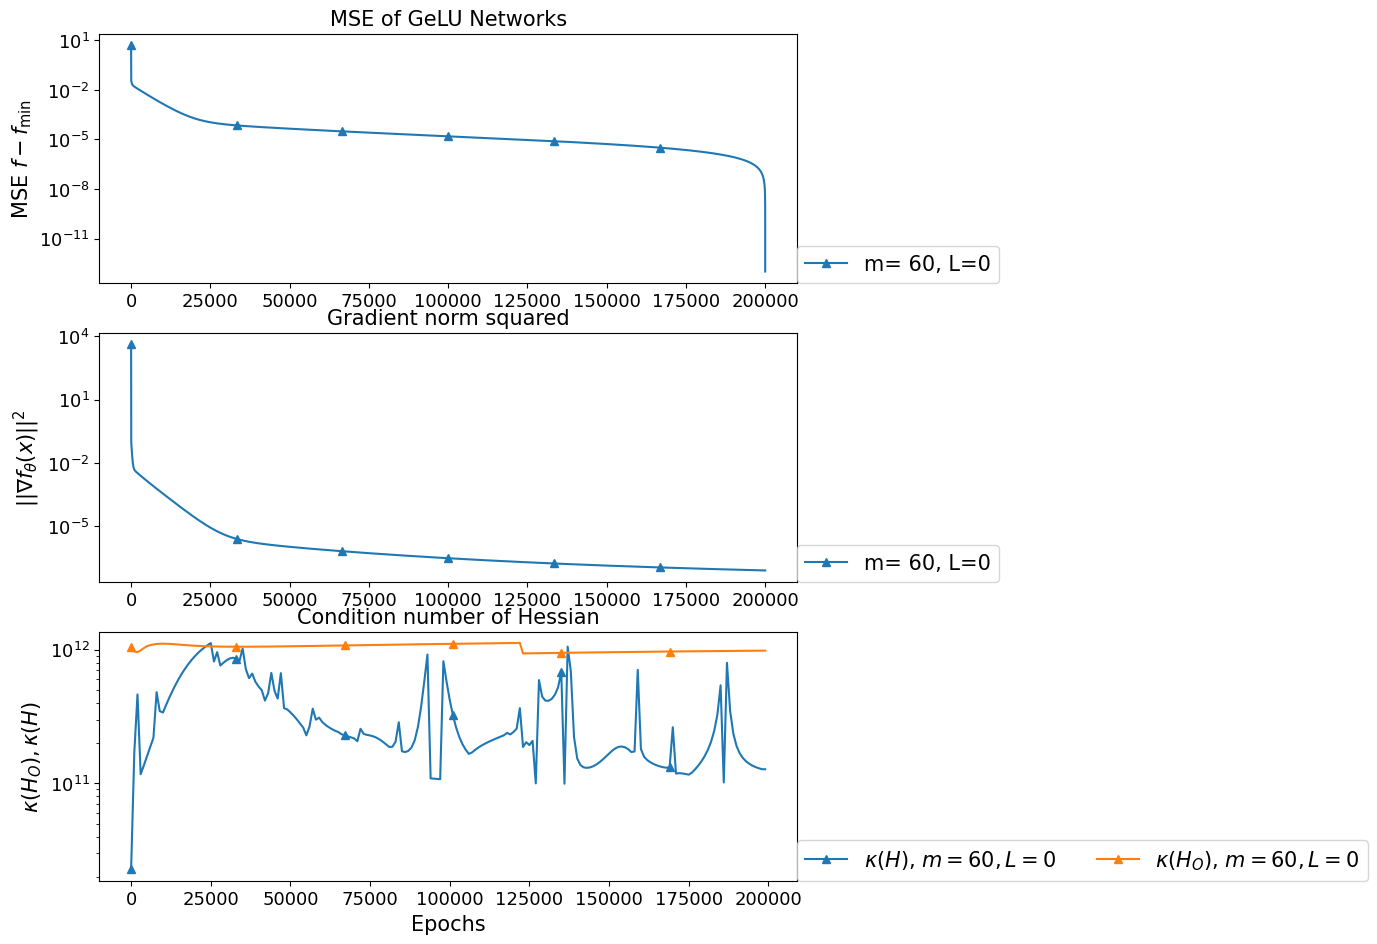

In [26]:
plot_diff_H_H_O_elementwise(cond_infos_gelu, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='GeLU')

plot_extreme_eigenvalues(cond_infos_gelu, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='GeLU')

plot_training_overview(loss_values_gelu, grad_norm_squared_gelu, cond_infos_gelu, num_param, m_L_config, epochs, calc_every_x_epoch,
                       title1='MSE of GeLU Networks', filetitle='GeLU')

### Train ReLU network for different initialization seeds 

In [27]:
# Train ReLU networks
epochs = 200000
calc_every_x_epoch = 1000
# lrs = [0.024, 0.013, 0.011, 0.005, 0.0015, 0.001] 
lrs = [0.001]
seeds = [314159, 2718182, 1618033, 112358, 1361015]
# seeds = [314159, 2718182]

loss_values_relu_seeds = []
grad_norm_squared_relu_seeds = []
cond_infos_relu_seeds = []

for seed in seeds:
    _loss_values_relu, _grad_norm_squared_relu, _cond_infos_relu = train_network_configurations(Leaky_ReLU_Networks, x_train, y_train, loss_func, m_L_config, 
                                                                 epochs, lrs, optimizer='SGD', 
                                                                 calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                             verbose_level=0, seed=seed)
    
    loss_values_relu_seeds.append(_loss_values_relu)
    grad_norm_squared_relu_seeds.append(_grad_norm_squared_relu)
    cond_infos_relu_seeds.append(_cond_infos_relu)



Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  2.232e+00


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 1.5255e+00
Epoch: 20002 	 loss= 1.8069e-03
Epoch: 40003 	 loss= 4.0558e-04
Epoch: 60004 	 loss= 1.7709e-04
Epoch: 80005 	 loss= 1.1570e-04
Epoch: 100006 	 loss= 8.2126e-05
Epoch: 120007 	 loss= 5.7096e-05
Epoch: 140008 	 loss= 4.2931e-05
Epoch: 160009 	 loss= 3.4266e-05
Epoch: 180010 	 loss= 2.8376e-05
Epoch: 200000 	 loss= 2.4261e-05
Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  3.380e-01


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 3.2433e-01
Epoch: 20002 	 loss= 2.6095e-03
Epoch: 40003 	 loss= 3.5501e-04
Epoch: 60004 	 loss= 1.1738e-04
Epoch: 80005 	 loss= 7.2536e-05
Epoch: 100006 	 loss= 5.1850e-05
Epoch: 120007 	 loss= 3.9000e-05
Epoch: 140008 	 loss= 2.9847e-05
Epoch: 160009 	 loss= 2.3605e-05
Epoch: 180010 	 loss= 1.9475e-05
Epoch: 200000 	 loss= 1.6568e-05
Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  5.837e+01


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 7.2955e+01
Epoch: 20002 	 loss= 9.4622e-04
Epoch: 40003 	 loss= 2.0443e-04
Epoch: 60004 	 loss= 1.0747e-04
Epoch: 80005 	 loss= 8.0347e-05
Epoch: 100006 	 loss= 6.3671e-05
Epoch: 120007 	 loss= 5.2827e-05
Epoch: 140008 	 loss= 4.6691e-05
Epoch: 160009 	 loss= 4.2549e-05
Epoch: 180010 	 loss= 3.9357e-05
Epoch: 200000 	 loss= 3.5359e-05
Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  1.287e+01


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 7.6575e+00
Epoch: 20002 	 loss= 1.1638e-03
Epoch: 40003 	 loss= 2.6032e-04
Epoch: 60004 	 loss= 1.0548e-04
Epoch: 80005 	 loss= 6.9284e-05
Epoch: 100006 	 loss= 5.5061e-05
Epoch: 120007 	 loss= 4.6017e-05
Epoch: 140008 	 loss= 3.8978e-05
Epoch: 160009 	 loss= 3.3562e-05
Epoch: 180010 	 loss= 2.9010e-05
Epoch: 200000 	 loss= 2.5212e-05
Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  7.858e+01


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 4.2520e+01
Epoch: 20002 	 loss= 8.2069e-04
Epoch: 40003 	 loss= 2.2404e-04
Epoch: 60004 	 loss= 1.4129e-04
Epoch: 80005 	 loss= 1.1179e-04
Epoch: 100006 	 loss= 9.3805e-05
Epoch: 120007 	 loss= 7.8747e-05
Epoch: 140008 	 loss= 6.9550e-05
Epoch: 160009 	 loss= 6.2746e-05
Epoch: 180010 	 loss= 5.7852e-05
Epoch: 200000 	 loss= 5.3838e-05


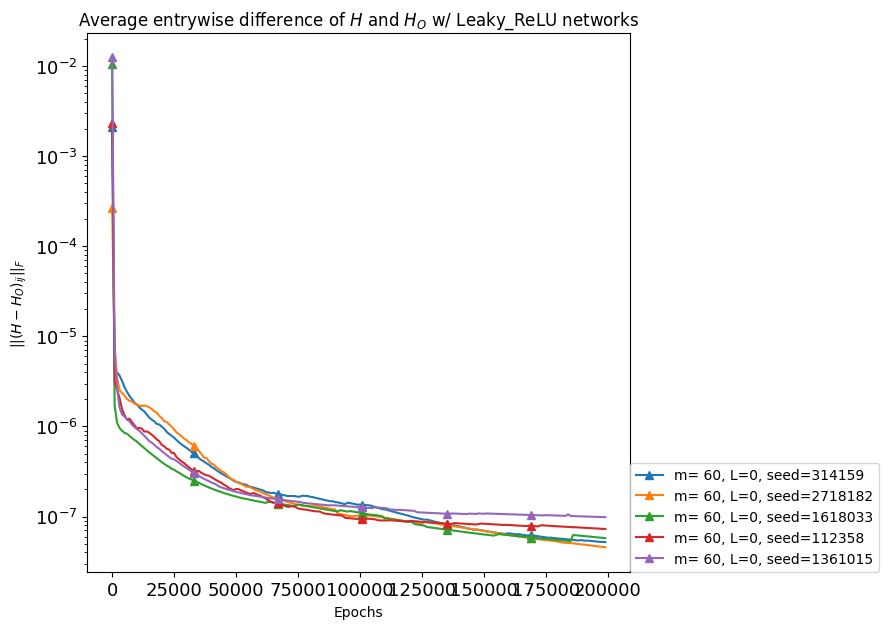

In [28]:
plt.figure(figsize=(7,7))

filetitle = 'Leaky_ReLU'

for i,seed in enumerate(seeds):

    cond_infos = cond_infos_relu_seeds[i]
    
    markers = ['^', 's', 'o', '*', 'p','v', '<']
    markevery = int(epochs/6)+1
    markevery2 = int(epochs/(6*calc_every_x_epoch))+1

    indx = list(np.arange(1,epochs,calc_every_x_epoch))
    indx.insert(0,0)

    for ind in range(len(num_param)):
        plt.semilogy(indx,np.array(cond_infos['diff_H_H_os'][ind])/(num_param[ind]**2), 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='m= %d, L=%d, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))

        plt.title('Average entrywise difference of $H$ and $H_O$ w/ ' + filetitle + ' networks')
        plt.xlabel('Epochs')
        plt.ylabel(r'$\||(H - H_O)_{ij}\||_F$')
        plt.legend(loc=(1,0), ncols=1)
        
    filename = 'figures/' + 'diff_H_H_O_elementwise_' + filetitle + '_diff_seeds.pdf'

    plt.savefig(filename, bbox_inches='tight')

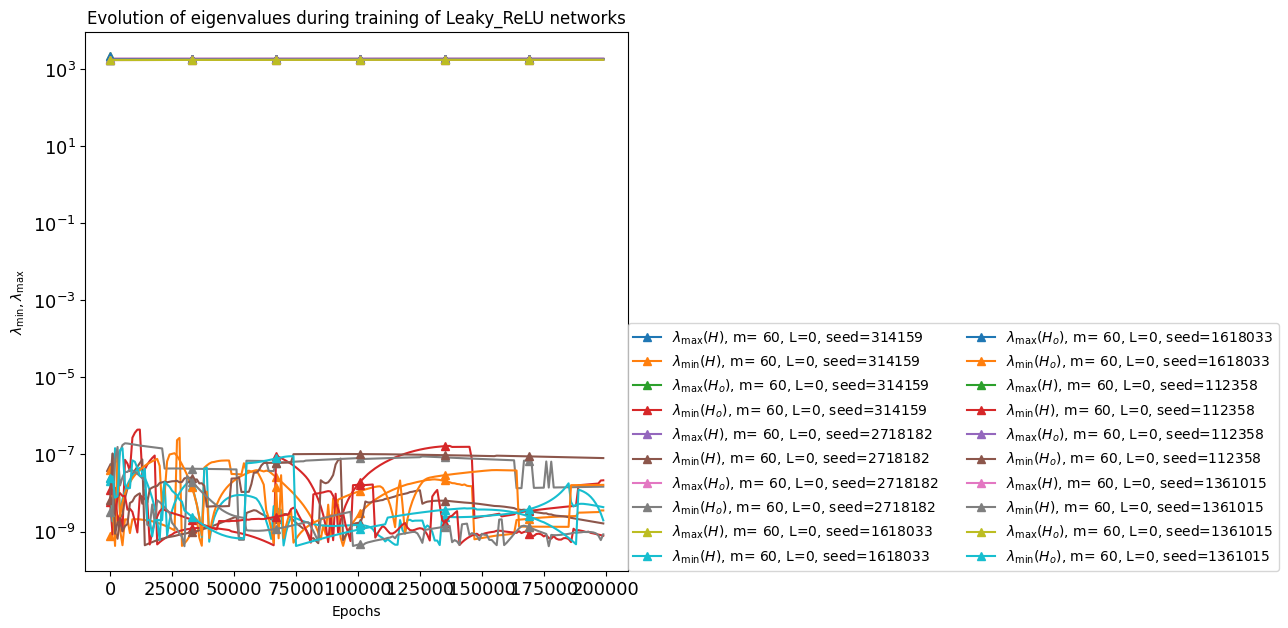

In [29]:
plt.figure(figsize=(7,7))

filetitle='Leaky_ReLU'

for i,seed in enumerate(seeds):
    
    cond_infos = cond_infos_relu_seeds[i]

    markers = ['^', 's', 'o', '*', 'p','v', '<']
    markevery = int(epochs/6)+1
    markevery2 = int(epochs/(6*calc_every_x_epoch))+1

    indx = list(np.arange(1,epochs,calc_every_x_epoch))
    indx.insert(0,0)
    for ind in range(len(num_param)):
        plt.semilogy(indx, cond_infos['lam_abs_maxs_H'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\lambda_\max(H)$, m= %d, L=%d, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))
    for ind in range(len(num_param)):
        plt.semilogy(indx, cond_infos['lam_abs_mins_H'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\lambda_\min(H)$, m= %d, L=%d, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))
    for ind in range(len(num_param)):
        plt.semilogy(indx, cond_infos['lam_abs_maxs_H'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\lambda_\max(H_o)$, m= %d, L=%d, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))
    for ind in range(len(num_param)):
        plt.semilogy(indx, cond_infos['lam_abs_mins_H_o'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\lambda_\min(H_o)$, m= %d, L=%d, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))

    plt.xlabel('Epochs')
    plt.ylabel(r'$\lambda_{\min}, \lambda_{\max}$')
    plt.legend(loc=(1,0), ncols=2)
    plt.title('Evolution of eigenvalues during training of ' + filetitle + ' networks')
    
    filename = 'figures/' + 'extreme_evals_during_training_' + filetitle + '_diff_seeds.pdf'

    plt.savefig(filename, bbox_inches='tight')

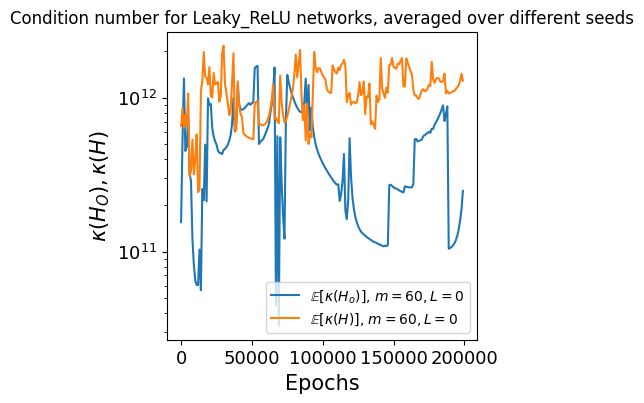

In [30]:
filetitle = 'Leaky_ReLU'

indx = list(np.arange(1,epochs,calc_every_x_epoch))
indx.insert(0,0)

avge = np.average([cond_infos_relu_seeds[i]['H_o_conds'][0] for i in range(len(seeds))],axis=0)
avge2 = np.average([cond_infos_relu_seeds[i]['H_conds'][0] for i in range(len(seeds))],axis=0)
plt.semilogy(indx, avge, label='$\mathbb{E}[\kappa(H_o)]$, $m= %d, L=%d$' % (m_L_config[ind][0], m_L_config[ind][1]))
plt.semilogy(indx, avge2, label='$\mathbb{E}[\kappa(H)]$, $m= %d, L=%d$' % (m_L_config[ind][0], m_L_config[ind][1]))
plt.legend()
plt.ylabel('$\kappa(H_O), \kappa(H)$', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.title('Condition number for ' + filetitle + ' networks, averaged over different seeds')

filename = 'figures/' + 'avg_cond_num_' + filetitle + '_networks' + '_diff_seeds.pdf'

plt.savefig(filename, bbox_inches='tight')

min MSE loss = 2.426e-05
min MSE loss = 1.657e-05
min MSE loss = 3.536e-05
min MSE loss = 2.521e-05
min MSE loss = 5.384e-05


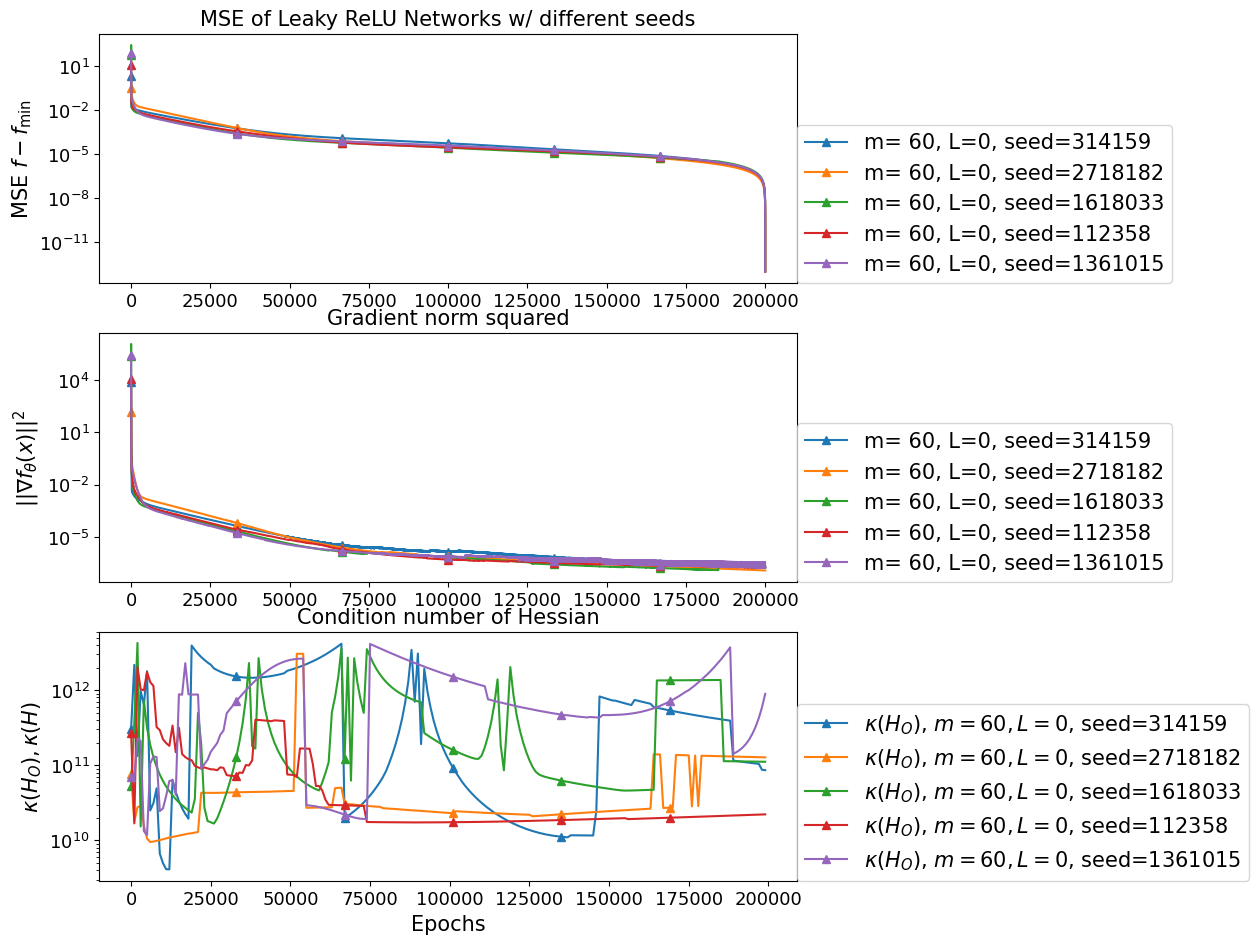

In [31]:
title1='MSE of Leaky ReLU Networks w/ different seeds'
filetitle='Leaky_ReLU'

plt.figure(figsize=(9,11))

for i,seed in enumerate(seeds):
    
    loss_values = loss_values_relu_seeds[i]
    grad_norm_squared = grad_norm_squared_relu_seeds[i]

    
    cond_infos = cond_infos_relu_seeds[i]
    
    markers = ['^', 's', 'o', '*', 'p','v', '<']
    markevery = int(epochs/6)+1
    markevery2 = int(epochs/(6*calc_every_x_epoch))+1

    epsilon = 1e-13

    min_loss_val = min(np.array(loss_values).flatten())
    print('min MSE loss = %1.3e' %min_loss_val)

    loss_to_plot = np.array(loss_values) - min_loss_val + epsilon


    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13)

    plt.subplot(311)
    for ind in range(len(num_param)):
        plt.semilogy(loss_to_plot[ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery+(ind%7), 
                     label='m= %d, L=%d, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))

        plt.title(title1, fontsize=15)
        plt.ylabel('MSE $f-f_{\min}$', fontsize=15)
        plt.legend(loc=(1,0), ncols=1, fontsize=15)

    plt.subplot(312)
    for ind in range(len(num_param)):
        plt.semilogy(np.array(grad_norm_squared[ind])+epsilon, 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery+(ind%7), 
                     label='m= %d, L=%d, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))

        plt.title('Gradient norm squared', fontsize=15)
        plt.ylabel(r'$\||\nabla f_{\theta} (x) \||^2 $', fontsize=15)
        plt.legend(loc=(1,0), ncols=1, fontsize=15)



    plt.subplot(313)

    indx = list(np.arange(1,epochs,calc_every_x_epoch))
    indx.insert(0,0)

#     for ind in range(len(num_param)):
#         plt.semilogy(indx,cond_infos['H_conds'][ind], 
#                      marker= markers[ind%len(markers)], 
#                      markevery=markevery2+(ind%7), 
#                      label='$\kappa(H)$, $m= %d, L=%d$, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))

    for ind in range(len(num_param)):
        plt.semilogy(indx,cond_infos['H_o_conds'][ind], 
                     marker= markers[ind%len(markers)], 
                     markevery=markevery2+(ind%7), 
                     label='$\kappa(H_O)$, $m= %d, L=%d$, seed=%d' % (m_L_config[ind][0], m_L_config[ind][1], seed))

    plt.title('Condition number of Hessian', fontsize=15)
    plt.legend(loc=(1,0), ncols=1, fontsize=15)
    plt.ylabel('$\kappa(H_O), \kappa(H)$', fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    
    filename = 'figures/' + 'training_' + filetitle + '_networks' + '_diff_seeds_H_O.pdf'

    plt.savefig(filename, bbox_inches='tight')

## Train Residual networks

In [32]:
# Train Linear Residual networks

epochs=2000
calc_every_x_epoch=50
# lrs = [0.02, 0.007, 0.003, 0.001, 0.0006, 0.0003] 
lrs = [0.001]

# loss_values_linear_res, grad_norm_squared_linear_res = train_network_configurations(Linear_Res_Networks, x_train, y_train, loss_func, m_L_config, 
#                                                              epochs, lrs, optimizer='SGD', 
#                                                              calc_cond_num=False, 
#                                                              verbose_level=0, seed=314159)

loss_values_linear_res, grad_norm_squared_linear_res, cond_infos_linear_res = train_network_configurations(
                                                                                 Linear_Res_Networks, x_train, y_train, loss_func, m_L_config, 
                                                                                 epochs, lrs, optimizer='SGD', 
                                                                                 calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                                                 verbose_level=0, seed=314159)

Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  1.073e+00


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 5.4514e-01
Epoch: 202 	 loss= 1.0420e-02
Epoch: 403 	 loss= 1.0342e-02
Epoch: 604 	 loss= 1.0341e-02
Epoch: 805 	 loss= 1.0341e-02
Epoch: 1006 	 loss= 1.0341e-02
Epoch: 1207 	 loss= 1.0341e-02
Epoch: 1408 	 loss= 1.0341e-02
Epoch: 1609 	 loss= 1.0341e-02
Epoch: 1810 	 loss= 1.0341e-02
Epoch: 2000 	 loss= 1.0341e-02


min MSE loss = 1.034e-02


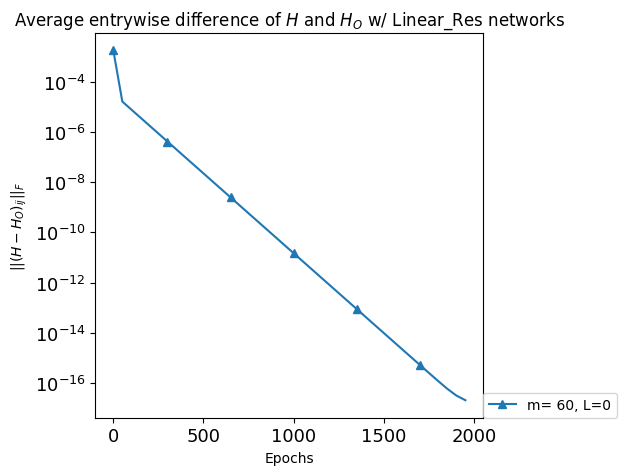

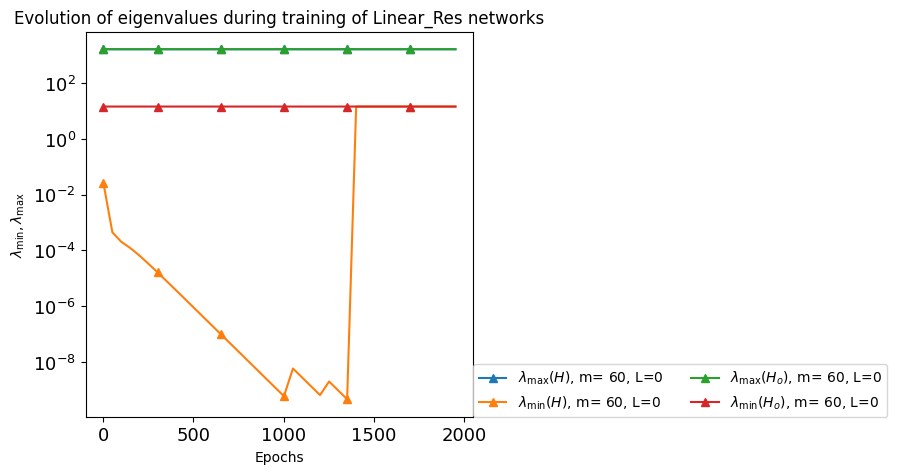

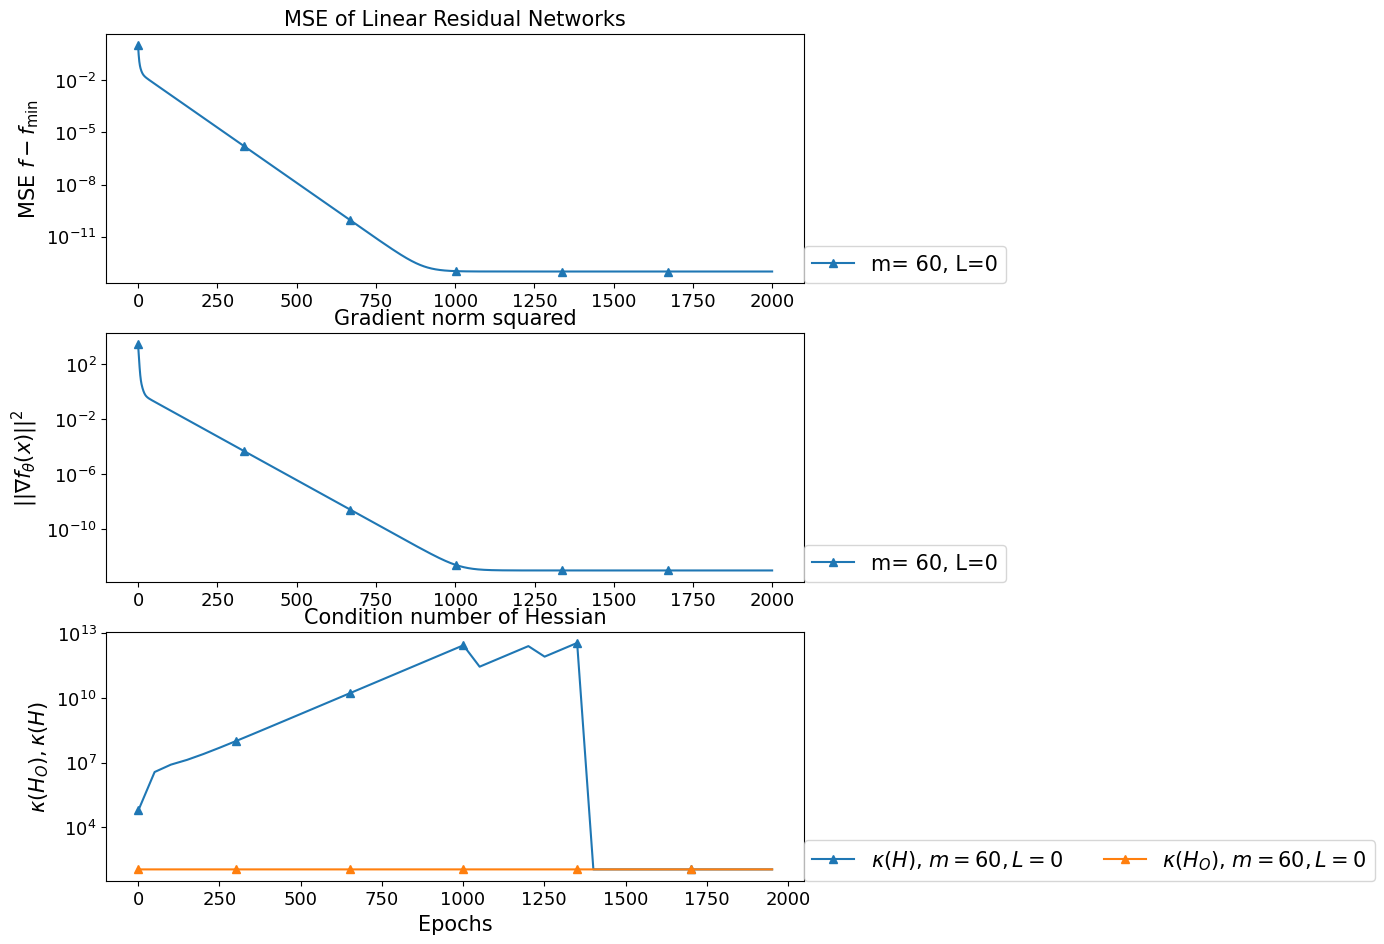

In [33]:
plot_diff_H_H_O_elementwise(cond_infos_linear_res, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='Linear_Res')

plot_extreme_eigenvalues(cond_infos_linear_res, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='Linear_Res')

plot_training_overview(loss_values_linear_res, grad_norm_squared_linear_res, cond_infos_linear_res, num_param, m_L_config, epochs, calc_every_x_epoch,
                       title1='MSE of Linear Residual Networks', filetitle='Linear_Res')

In [34]:
# Train ReLU Residual networks

epochs=200000
calc_every_x_epoch=1000
# lrs = [0.02, 0.007, 0.003, 0.001, 0.0006, 0.0003] 
lrs = [0.001]

# loss_values_relu_res, grad_norm_squared_relu_res = train_network_configurations(ReLU_Res_Networks, x_train, y_train, loss_func, m_L_config, 
#                                                              epochs, lrs, optimizer='SGD', 
#                                                              calc_cond_num=False, 
#                                                              verbose_level=0, seed=314159)

loss_values_relu_res, grad_norm_squared_relu_res, cond_infos_relu_res = train_network_configurations(
                                                                                 ReLU_Res_Networks, x_train, y_train, loss_func, m_L_config, 
                                                                                 epochs, lrs, optimizer='SGD', 
                                                                                 calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                                                 verbose_level=0, seed=314159)

Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  6.342e-01


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 7.1085e-02
Epoch: 20002 	 loss= 2.7694e-04
Epoch: 40003 	 loss= 1.2097e-04
Epoch: 60004 	 loss= 8.8444e-05
Epoch: 80005 	 loss= 7.2389e-05
Epoch: 100006 	 loss= 6.1272e-05
Epoch: 120007 	 loss= 4.5668e-05
Epoch: 140008 	 loss= 3.5201e-05
Epoch: 160009 	 loss= 2.9189e-05
Epoch: 180010 	 loss= 2.4998e-05
Epoch: 200000 	 loss= 2.1774e-05


min MSE loss = 2.177e-05


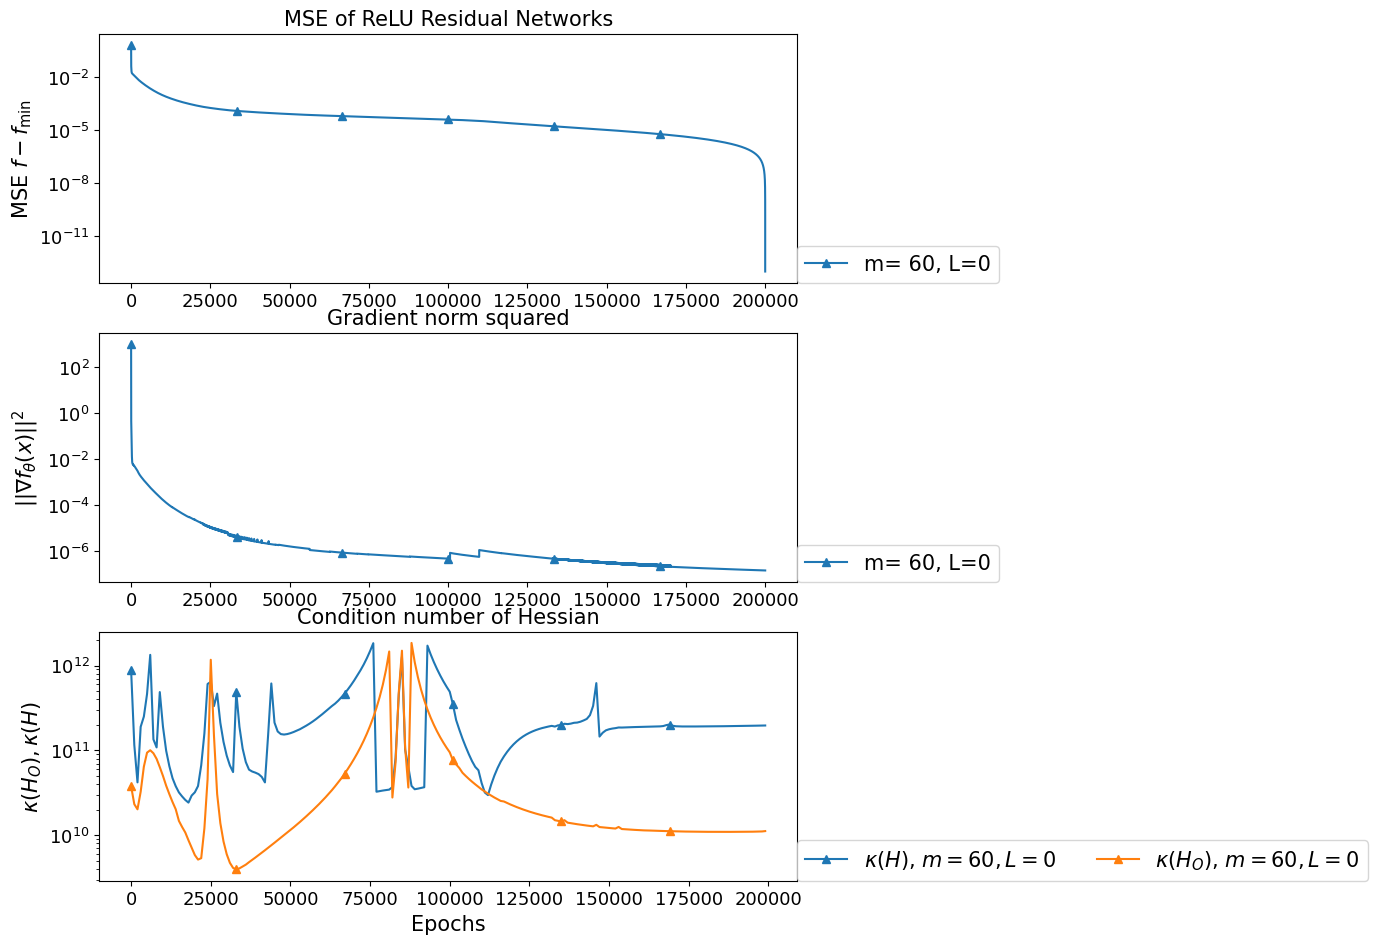

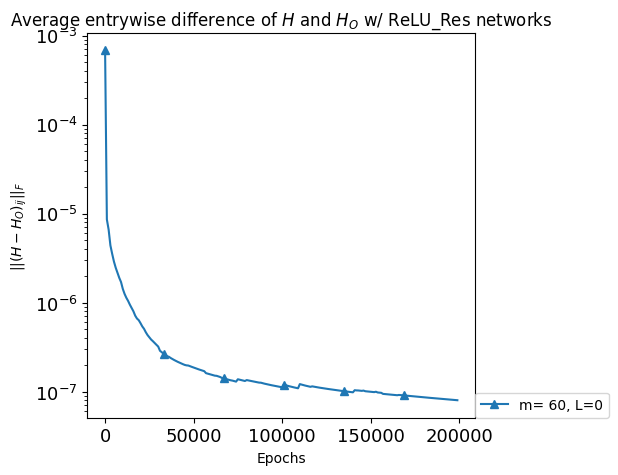

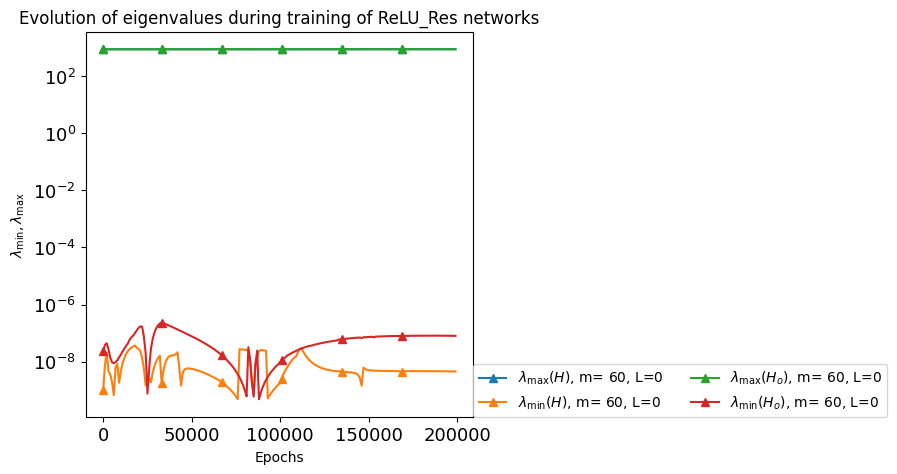

In [35]:
plot_training_overview(loss_values_relu_res, grad_norm_squared_relu_res, cond_infos_relu_res, num_param, m_L_config, epochs, calc_every_x_epoch,
                       title1='MSE of ReLU Residual Networks', filetitle='ReLU_Res')

plot_diff_H_H_O_elementwise(cond_infos_relu_res, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='ReLU_Res')

plot_extreme_eigenvalues(cond_infos_relu_res, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='ReLU_Res')


In [36]:
# Train Leaky ReLU Residual networks

epochs=200000
calc_every_x_epoch=1000
# lrs = [0.02, 0.007, 0.003, 0.001, 0.0006, 0.0003] 
lrs = [0.001]

# loss_values_leaky_relu_res, grad_norm_squared_leaky_relu_res = train_network_configurations(Leaky_ReLU_Res_Networks, x_train, y_train, loss_func, m_L_config, 
#                                                              epochs, lrs, optimizer='SGD', 
#                                                              calc_cond_num=False, 
#                                                              verbose_level=0, seed=314159)

loss_values_leaky_relu_res, grad_norm_squared_leaky_relu_res, cond_infos_leaky_relu_res = train_network_configurations(
                                                                                 Leaky_ReLU_Res_Networks, x_train, y_train, loss_func, m_L_config, 
                                                                                 epochs, lrs, optimizer='SGD', 
                                                                                 calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                                                 verbose_level=0, seed=314159)

Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Epoch: 0 	 loss=  2.943e+00


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 2.1217e+00
Epoch: 20002 	 loss= 1.7768e-03
Epoch: 40003 	 loss= 3.9791e-04
Epoch: 60004 	 loss= 1.7371e-04
Epoch: 80005 	 loss= 1.1369e-04
Epoch: 100006 	 loss= 8.1454e-05
Epoch: 120007 	 loss= 6.1556e-05
Epoch: 140008 	 loss= 4.9203e-05
Epoch: 160009 	 loss= 3.8587e-05
Epoch: 180010 	 loss= 3.1331e-05
Epoch: 200000 	 loss= 2.6434e-05


min MSE loss = 2.643e-05


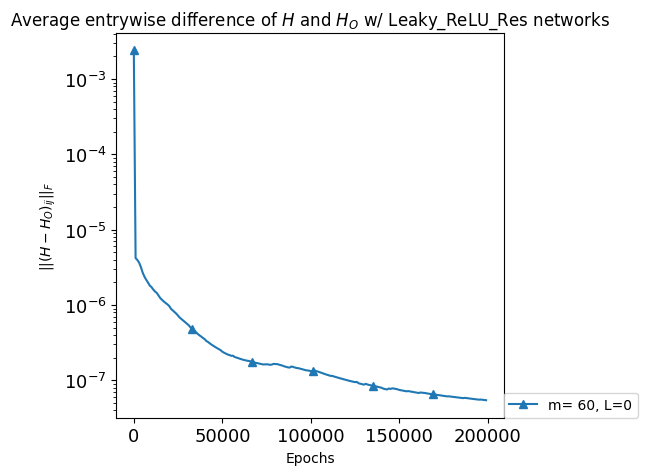

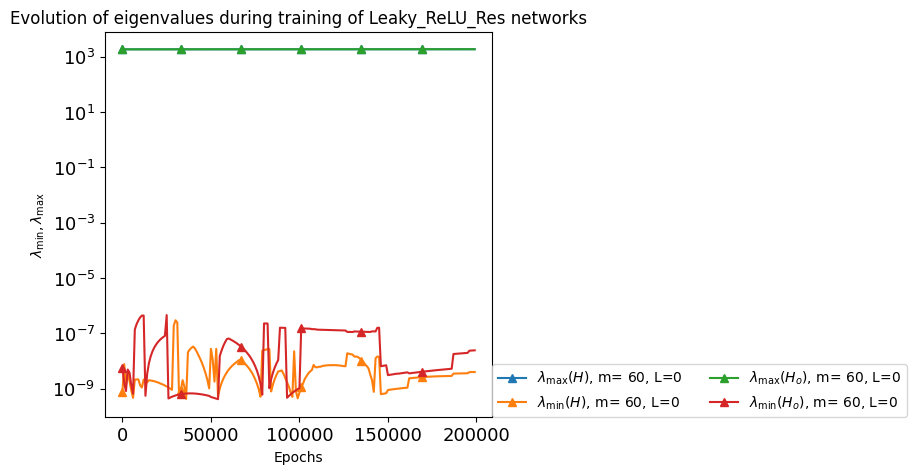

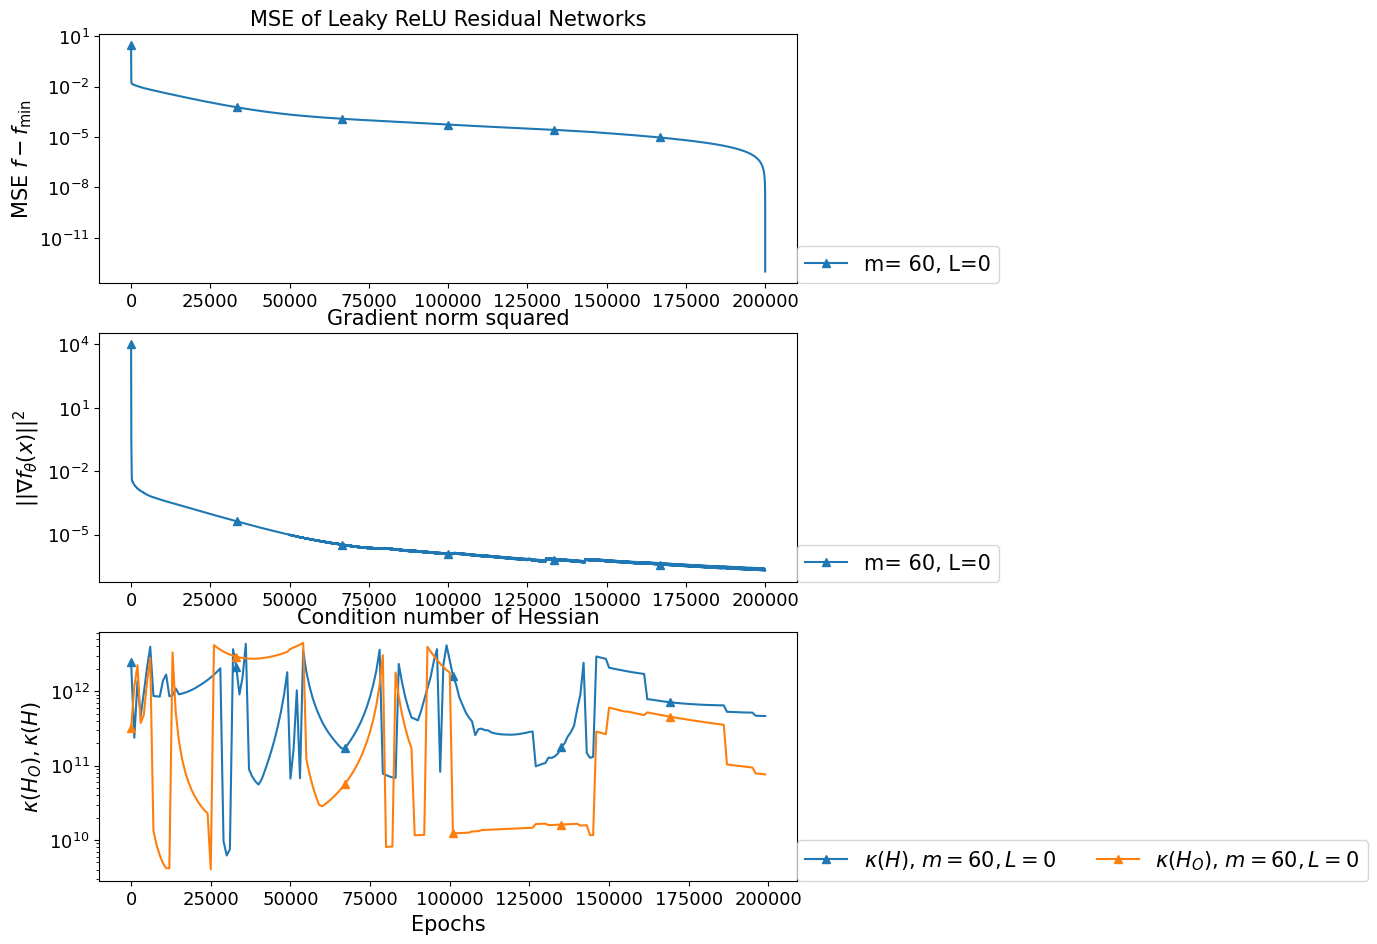

In [37]:
plot_diff_H_H_O_elementwise(cond_infos_leaky_relu_res, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='Leaky_ReLU_Res')

plot_extreme_eigenvalues(cond_infos_leaky_relu_res, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='Leaky_ReLU_Res')

plot_training_overview(loss_values_leaky_relu_res, grad_norm_squared_leaky_relu_res, cond_infos_leaky_relu_res, num_param, m_L_config, epochs, calc_every_x_epoch,
                       title1='MSE of Leaky ReLU Residual Networks', filetitle='Leaky_ReLU_Res')

In [38]:
# Train GeLU Residual networks

epochs=200000
calc_every_x_epoch=1000
# lrs = [0.02, 0.007, 0.003, 0.001, 0.0006, 0.0003] 
lrs = [0.001]

# loss_values_gelu_res, grad_norm_squared_gelu_res = train_network_configurations(GeLU_Res_Networks, x_train, y_train, loss_func, m_L_config, 
#                                                              epochs, lrs, optimizer='SGD', 
#                                                              calc_cond_num=False, 
#                                                              verbose_level=0, seed=314159)

loss_values_gelu_res, grad_norm_squared_gelu_res, cond_infos_gelu_res = train_network_configurations(
                                                                                 GeLU_Res_Networks, x_train, y_train, loss_func, m_L_config, 
                                                                                 epochs, lrs, optimizer='SGD', 
                                                                                 calc_cond_num=True, calc_every_x_epoch=calc_every_x_epoch, 
                                                                                 verbose_level=0, seed=314159)

Training Networks...
Network configuration: d=2, k=1, m=60, L=0
Unsupported activation function. Using "linear" as non-linearity argument
Epoch: 0 	 loss=  4.909e+00


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch: 1 	 loss= 1.4918e+00
Epoch: 20002 	 loss= 1.8962e-04
Epoch: 40003 	 loss= 6.9595e-05
Epoch: 60004 	 loss= 5.1766e-05
Epoch: 80005 	 loss= 4.1698e-05
Epoch: 100006 	 loss= 3.5216e-05
Epoch: 120007 	 loss= 3.0696e-05
Epoch: 140008 	 loss= 2.7344e-05
Epoch: 160009 	 loss= 2.4732e-05
Epoch: 180010 	 loss= 2.2615e-05
Epoch: 200000 	 loss= 2.0849e-05


min MSE loss = 2.085e-05


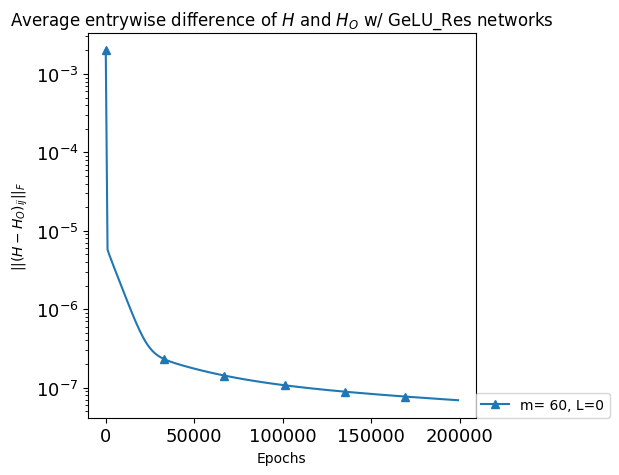

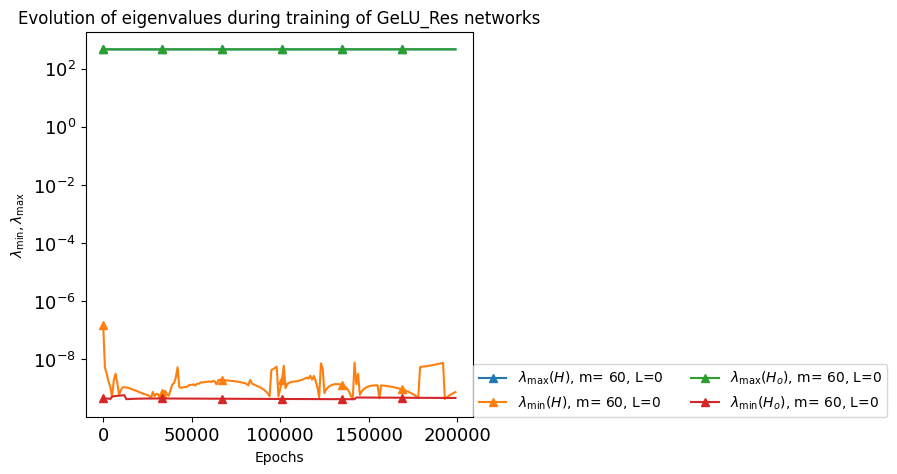

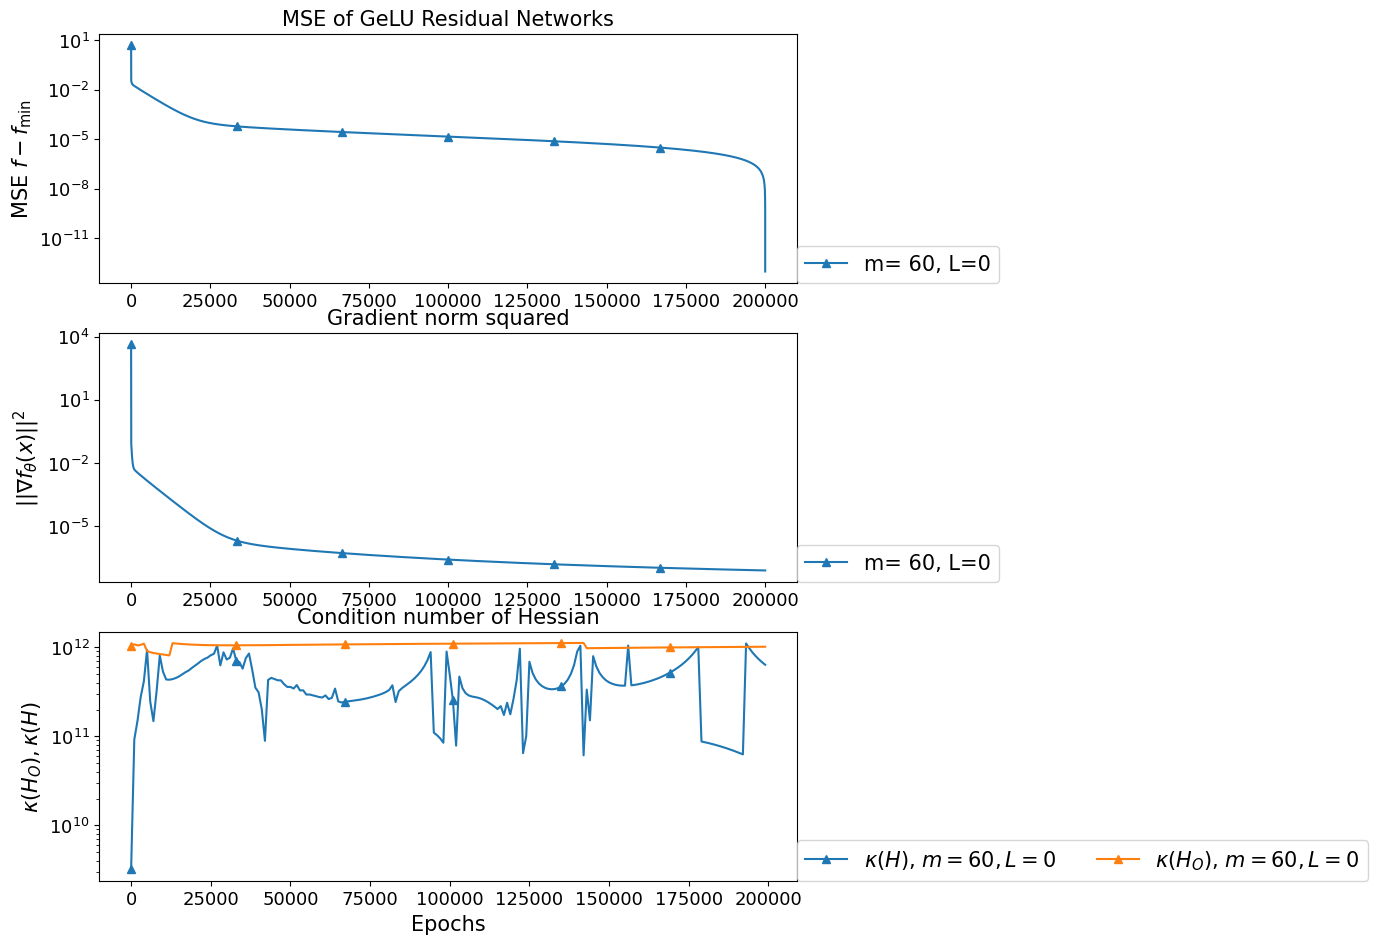

In [39]:
plot_diff_H_H_O_elementwise(cond_infos_gelu_res, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='GeLU_Res')

plot_extreme_eigenvalues(cond_infos_gelu_res, num_param, m_L_config, epochs, calc_every_x_epoch, filetitle='GeLU_Res')

plot_training_overview(loss_values_gelu_res, grad_norm_squared_gelu_res, cond_infos_gelu_res, num_param, m_L_config, epochs, calc_every_x_epoch,
                       title1='MSE of GeLU Residual Networks', filetitle='GeLU_Res')

### Calculate the accuracies of the models after training

In [40]:
train_dl_test = DataLoader(train_ds, batch_size=1)

In [41]:
for ind,network in enumerate(Linear_Networks):
    
    print('Accuracies for Linear Networks...')
    print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))
    
    train_acc = sum(accuracy(network(xb), yb) for xb, yb in train_dl_test)/len(y_train)

    test_acc = sum(accuracy(network(xb), yb) for xb, yb in valid_dl)/len(y_val)

    print('Train accuracy: %.3f' % train_acc)
    print('Test accuracy: %.3f' % test_acc)

Accuracies for Linear Networks...
Network configuration: d=2, k=1, m=60, L=0
Train accuracy: 1.000
Test accuracy: 1.000


In [42]:
for ind,network in enumerate(ReLU_Networks):
    
    print('Accuracies for ReLU Networks...')
    print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))
    
    train_acc = sum(accuracy(network(xb), yb) for xb, yb in train_dl_test)/len(y_train)

    test_acc = sum(accuracy(network(xb), yb) for xb, yb in valid_dl)/len(y_val)

    print('Train accuracy: %.7f' % train_acc)
    print('Test accuracy: %.7f' % test_acc)

Accuracies for ReLU Networks...
Network configuration: d=2, k=1, m=60, L=0
Train accuracy: 1.0000000
Test accuracy: 1.0000000


In [43]:
for ind,network in enumerate(Leaky_ReLU_Networks):
    
    print('Accuracies for Leaky ReLU Networks...')
    print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))
    
    train_acc = sum(accuracy(network(xb), yb) for xb, yb in train_dl_test)/len(y_train)

    test_acc = sum(accuracy(network(xb), yb) for xb, yb in valid_dl)/len(y_val)

    print('Train accuracy: %.7f' % train_acc)
    print('Test accuracy: %.7f' % test_acc)

Accuracies for Leaky ReLU Networks...
Network configuration: d=2, k=1, m=60, L=0
Train accuracy: 1.0000000
Test accuracy: 1.0000000


In [44]:
for ind,network in enumerate(GeLU_Networks):
    
    print('Accuracies for GeLU Networks...')
    print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))
    
    train_acc = sum(accuracy(network(xb), yb) for xb, yb in train_dl_test)/len(y_train)

    test_acc = sum(accuracy(network(xb), yb) for xb, yb in valid_dl)/len(y_val)

    print('Train accuracy: %.7f' % train_acc)
    print('Test accuracy: %.7f' % test_acc)
    
    

Accuracies for GeLU Networks...
Network configuration: d=2, k=1, m=60, L=0
Train accuracy: 1.0000000
Test accuracy: 1.0000000


In [45]:
for ind,network in enumerate(Linear_Res_Networks):
    
    print('Accuracies for Linear Residual Networks...')
    print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))
    
    train_acc = sum(accuracy(network(xb), yb) for xb, yb in train_dl_test)/len(y_train)

    test_acc = sum(accuracy(network(xb), yb) for xb, yb in valid_dl)/len(y_val)

    print('Train accuracy: %.3f' % train_acc)
    print('Test accuracy: %.3f' % test_acc)

Accuracies for Linear Residual Networks...
Network configuration: d=2, k=1, m=60, L=0
Train accuracy: 1.000
Test accuracy: 1.000


In [46]:
for ind,network in enumerate(ReLU_Res_Networks):
    
    print('Accuracies for ReLU Residual Networks...')
    print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))
    
    train_acc = sum(accuracy(network(xb), yb) for xb, yb in train_dl_test)/len(y_train)

    test_acc = sum(accuracy(network(xb), yb) for xb, yb in valid_dl)/len(y_val)

    print('Train accuracy: %.7f' % train_acc)
    print('Test accuracy: %.7f' % test_acc)

Accuracies for ReLU Residual Networks...
Network configuration: d=2, k=1, m=60, L=0
Train accuracy: 1.0000000
Test accuracy: 1.0000000


In [47]:
for ind,network in enumerate(Leaky_ReLU_Res_Networks):
    
    print('Accuracies for Leaky ReLU Residual Networks...')
    print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))
    
    train_acc = sum(accuracy(network(xb), yb) for xb, yb in train_dl_test)/len(y_train)

    test_acc = sum(accuracy(network(xb), yb) for xb, yb in valid_dl)/len(y_val)

    print('Train accuracy: %.7f' % train_acc)
    print('Test accuracy: %.7f' % test_acc)

Accuracies for Leaky ReLU Residual Networks...
Network configuration: d=2, k=1, m=60, L=0
Train accuracy: 1.0000000
Test accuracy: 1.0000000


In [48]:
for ind,network in enumerate(GeLU_Res_Networks):
    
    print('Accuracies for GeLU Residual Networks...')
    print('Network configuration: d=%d, k=%d, m=%d, L=%d' % (d, k, m_L_config[ind][0], m_L_config[ind][1]))
    
    train_acc = sum(accuracy(network(xb), yb) for xb, yb in train_dl_test)/len(y_train)

    test_acc = sum(accuracy(network(xb), yb) for xb, yb in valid_dl)/len(y_val)

    print('Train accuracy: %.7f' % train_acc)
    print('Test accuracy: %.7f' % test_acc)
    
    

Accuracies for GeLU Residual Networks...
Network configuration: d=2, k=1, m=60, L=0
Train accuracy: 1.0000000
Test accuracy: 1.0000000
